In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
import optuna
import statsmodels.api as sm
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import Ridge
import logging
import math
# 参数设置
num_features = 500  # 特征维度
N = 5000  # 样本数量
sigma_u = 0.3  # 技术无效率的标准差
sigma_v = 0.5  # 随机噪声的标准差
beta = np.zeros(num_features)
# 随机选择六个不同的索引位置
non_zero_indices = np.random.choice(num_features, 6, replace=False)

# 将随机选择的六个位置的 beta 值设置为 1 或 -1
# 使用 np.random.choice([1, -1], size=6) 来随机选择每个位置的值
beta[non_zero_indices] = np.random.choice([1, -1], size=6)

print(beta)
# 生成数据
x1 = np.random.uniform(0, 1, N)
x_random = np.random.normal(0, 1, (N, num_features - 1))
x = np.hstack([x1.reshape(-1, 1), x_random])
v = np.random.normal(0, sigma_v, N)
u = np.abs(np.random.normal(0, sigma_u, N))  # 半正态分布
y = x.dot(beta) + v - u

# 保存数据和参数
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

# 保存 x 和 y
np.save(os.path.join(data_dir, "x.npy"), x)
np.save(os.path.join(data_dir, "y.npy"), y)

# 保存真实参数
np.save(os.path.join(data_dir, "beta_true.npy"), beta)
np.save(os.path.join(data_dir, "sigma_u.npy"), sigma_u)
np.save(os.path.join(data_dir, "sigma_v.npy"), sigma_v)

print("数据生成完成并已保存！")
# 设置日志
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# 数据目录
#data_dir = "data"
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# 加载数据
x = np.load(os.path.join(data_dir, "x.npy"))
y = np.load(os.path.join(data_dir, "y.npy"))
beta_true = np.load(os.path.join(data_dir, "beta_true.npy"))
sigma_u = np.load(os.path.join(data_dir, "sigma_u.npy"))
sigma_v = np.load(os.path.join(data_dir, "sigma_v.npy"))



[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

In [2]:
# 加载数据
x = np.load(os.path.join(data_dir, "x.npy"))
y = np.load(os.path.join(data_dir, "y.npy"))
beta_true = np.load(os.path.join(data_dir, "beta_true.npy"))
sigma_u = np.load(os.path.join(data_dir, "sigma_u.npy"))
sigma_v = np.load(os.path.join(data_dir, "sigma_v.npy"))

print("yes")

yes


In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import optuna
import os

# MLE自适应Lasso方法
class MLEAdaptiveLasso:
    def __init__(self, num_features, beta_true):
        self.num_features = num_features
        self.beta_true = beta_true

    def stochastic_frontier_mle_with_adaptive_lasso(self, x, y, lambda_=1.0, threshold=1e-2):
        x_df = pd.DataFrame(x)
        y_series = pd.Series(y)

        ridge = Ridge(alpha=0.1)
        ridge.fit(x, y)
        beta_initial = ridge.coef_
        weights = 1 / (np.abs(beta_initial) + 1e-10)
        weights = weights / np.max(weights)

        def logLikFun(param):
            beta = param[:-2]
            sigma_sq = np.exp(param[-2])  # 确保 sigma_sq 为正
            lambda0 = np.exp(param[-1])  # 确保 lambda0 为正
            epsilon = y_series - np.dot(x_df, beta)
            term1 = -0.5 * x_df.shape[0] * np.log(sigma_sq)
            term2 = -0.5 * np.sum(epsilon**2) / sigma_sq
            term3 = -np.sum(np.log(norm.cdf(-epsilon * lambda0 / np.sqrt(sigma_sq)) + 1e-10))
            lasso_penalty = lambda_ * np.sum(weights * np.abs(beta))
            return -(term1 + term2 + term3) + lasso_penalty

        ols = sm.OLS(y_series, x_df).fit()
        init_params = np.append(ols.params, [0.5, 1.0])
        result = minimize(logLikFun, init_params, method='L-BFGS-B')
        beta = result.x[:-2]
        sigma_sq = np.exp(result.x[-2])  # 确保 sigma_sq 为正
        lambda0 = np.exp(result.x[-1])  # 确保 lambda0 为正
        beta[np.abs(beta) < threshold] = 0
        selected_vars = np.where(beta != 0)[0]
        return beta, sigma_sq, lambda0, selected_vars

    def calculate_bic(self, x, y, beta, sigma_sq, lambda0):
        epsilon = y - np.dot(x, beta)
        log_likelihood = -0.5 * x.shape[0] * np.log(sigma_sq) - 0.5 * np.sum(epsilon**2) / sigma_sq - np.sum(np.log(norm.cdf(-epsilon * lambda0 / np.sqrt(sigma_sq)) + 1e-10))
        k = np.sum(beta != 0)  # 非零系数的数量
        n = x.shape[0]  # 样本数量
        bic = -2 * log_likelihood + k * np.log(n)
        return bic

    def calculate_fr(self, selected_vars):
        true_non_zero = np.where(self.beta_true != 0)[0]
        fr = len(np.setdiff1d(selected_vars, true_non_zero)) / len(true_non_zero)
        return fr

    def calculate_tpr_fpr(self, selected_vars):
        true_selected = np.where(self.beta_true != 0)[0]
        selected = selected_vars
        tp = len(np.intersect1d(selected, true_selected))
        fp = len(np.setdiff1d(selected, true_selected))
        fn = len(np.setdiff1d(true_selected, selected))
        tn = self.num_features - tp - fp - fn
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        return tpr, fpr

    def run_experiment_with_bic(self, x, y, lambda_values):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        bic_values = []
        results_list = []

        for lambda_ in lambda_values:
            beta, sigma_sq, lambda0, selected_vars = self.stochastic_frontier_mle_with_adaptive_lasso(x_train, y_train, lambda_=lambda_)
            bic = self.calculate_bic(x_train, y_train, beta, sigma_sq, lambda0)
            bic_values.append(bic)
            x_test_selected = x_test[:, selected_vars]
            y_pred = x_test_selected.dot(beta[selected_vars])
            test_mse = np.mean((y_test - y_pred) ** 2)
            fr = self.calculate_fr(selected_vars)
            tpr, fpr = self.calculate_tpr_fpr(selected_vars)
            results = {
                "method": "MLE_Adaptive_Lasso",
                "lambda": lambda_,
                "mse": test_mse,
                "fr": fr,
                "sse": np.sum((beta - self.beta_true) ** 2),
                "tpr": tpr,
                "fpr": fpr,
                "bic": bic,
                "beta_hat": beta.tolist()
            }
            results_list.append(results)

        # 选择使BIC最小的lambda
        best_lambda_index = np.argmin(bic_values)
        best_results = results_list[best_lambda_index]

        return best_results, results_list

# Stochastic Frontier Model类
class StochasticFrontierModel(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.beta = nn.Parameter(torch.tensor(num_features * [1.0], dtype=torch.float32))
        self.log_sigma2 = nn.Parameter(torch.tensor(0.0))
        self.log_lambda0 = nn.Parameter(torch.tensor(0.0))

    def predict(self, x):
        return torch.matmul(x, self.beta)

    def forward(self, x, y, lambda_reg=1):
        sigma2 = torch.exp(self.log_sigma2)  # 确保 sigma2 为正
        lambda0 = torch.exp(self.log_lambda0)  # 确保 lambda0 为正
        sigma = torch.sqrt(sigma2)
        epsilon = y - torch.sum(x * self.beta, dim=1)
        term1 = x.shape[0] * self.log_sigma2 / 2

        # Fix: Detach epsilon and convert to NumPy for norm.cdf
        epsilon_np = (-epsilon * lambda0 / sigma).detach().numpy()
        cdf_values = torch.tensor(norm.cdf(epsilon_np), dtype=torch.float32)
        term2 = -torch.sum(torch.log(cdf_values + 1e-10))

        term3 = torch.sum(epsilon**2) / (2 * sigma2)
        lasso_penalty = lambda_reg * torch.sum(torch.abs(self.beta))
        return (term1 + term2 + term3 + lasso_penalty) / x.shape[0]

# Stochastic Frontier Analysis类
class StochasticFrontierAnalysis:
    def __init__(self, num_features, beta_true, sigma_u, sigma_v):
        self.num_features = num_features
        self.beta_true = beta_true
        self.sigma_u = sigma_u
        self.sigma_v = sigma_v

    def standardize_data(self, x):
        mean = np.mean(x[:, 1:], axis=0)
        std = np.std(x[:, 1:], axis=0)
        x_standardized = np.column_stack([x[:, 0], (x[:, 1:] - mean) / std])
        return x_standardized, np.insert(mean, 0, 0), np.insert(std, 0, 1)

    def train_model_without_private(self, x, y, num_iters=3000, constraint=100, minibatch_size=50, lambda_reg=1):
        x, mean, std = self.standardize_data(x)
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        model = StochasticFrontierModel(num_features=self.num_features)
        losses = []
        gradients = []
        parameters = []

        for i in tqdm(range(1, num_iters + 1), desc="Training without privacy"):
            minibatch_indices = np.random.choice(x.shape[0], minibatch_size, replace=True)
            minibatch_x = x[minibatch_indices]
            minibatch_y = y[minibatch_indices]
            loss = model(minibatch_x, minibatch_y, lambda_reg)
            loss.backward()

            # Fix: Skip parameters with None gradients
            gradient = torch.cat([p.grad.flatten() for p in model.parameters() if p.grad is not None]).detach().numpy()

            pos_alphas = self.compute_alpha(constraint, gradient, model)
            neg_alphas = self.compute_alpha(-constraint, gradient, model)
            alphas = pos_alphas + neg_alphas
            min_alpha, size, corner_num = min(alphas, key=lambda x: x[0])
            corner = np.zeros(sum(p.numel() for p in model.parameters()))
            corner[corner_num] = size
            mu = 2 / (i + 2)
            with torch.no_grad():
                index = 0
                for p in model.parameters():
                    numel = p.numel()
                    p_flat = p.view(-1)
                    p_flat.copy_((1 - mu) * p_flat + mu * torch.tensor(corner[index:index+numel], dtype=torch.float32))
                    index += numel
            losses.append(loss.item())
            gradients.append(np.linalg.norm(gradient))
            parameters.append(model.state_dict().copy())
            model.zero_grad()

        min_loss_index = np.argmin(losses)
        model.load_state_dict(parameters[min_loss_index])

        # Fix: Avoid in-place modification of model.beta
        with torch.no_grad():
            beta_new = model.beta.clone()
            beta_new[torch.abs(beta_new) < 1e-3] = 0
            model.beta.copy_(beta_new)

        return model, mean, std, losses[-1], self.calculate_mse(model, x, y)

    def train_model_private(self, x, y, num_iters=3000, constraint=100, minibatch_size=50, lipschitz=1, epsilon=0.1, delta=1e-5, lambda_reg=1):
        x, mean, std = self.standardize_data(x)
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        model = StochasticFrontierModel(num_features=self.num_features)
        n = x.shape[0]
        m = sum(p.numel() for p in model.parameters())
        losses = []
        gradients = []
        parameters = []
        noise_para = lipschitz * constraint * math.sqrt(8 * num_iters * math.log(1 / delta)) / (n * epsilon)

        for i in tqdm(range(1, num_iters + 1), desc="Training with privacy"):
            minibatch_indices = np.random.choice(x.shape[0], minibatch_size, replace=True)
            minibatch_x = x[minibatch_indices]
            minibatch_y = y[minibatch_indices]
            loss = model(minibatch_x, minibatch_y, lambda_reg)
            loss.backward()

            # Fix: Skip parameters with None gradients
            gradient = torch.cat([p.grad.flatten() for p in model.parameters() if p.grad is not None]).detach().numpy()

            pos_alphas = self.compute_alpha_private(constraint, gradient, model, noise_para)
            neg_alphas = self.compute_alpha_private(-constraint, gradient, model, noise_para)
            alphas = pos_alphas + neg_alphas
            min_alpha, size, corner_num = min(alphas, key=lambda x: x[0])
            corner = np.zeros(m)
            corner[corner_num] = size
            mu = 2 / (i + 2)
            with torch.no_grad():
                index = 0
                for p in model.parameters():
                    numel = p.numel()
                    p_flat = p.view(-1)
                    p_flat.copy_((1 - mu) * p_flat + mu * torch.tensor(corner[index:index+numel], dtype=torch.float32))
                    index += numel
            losses.append(loss.item())
            gradients.append(np.linalg.norm(gradient))
            parameters.append(model.state_dict().copy())
            model.zero_grad()

        min_loss_index = np.argmin(losses)
        model.load_state_dict(parameters[min_loss_index])

        # Fix: Avoid in-place modification of model.beta
        with torch.no_grad():
            beta_new = model.beta.clone()
            beta_new[torch.abs(beta_new) < 1e-3] = 0
            model.beta.copy_(beta_new)

        return model, mean, std, losses[-1], self.calculate_mse(model, x, y)

    def compute_alpha(self, corner_size, gradient, model):
        alpha = gradient * corner_size
        corner_size = (np.ones(sum(p.numel() for p in model.parameters())) * corner_size).tolist()
        corner_num = np.arange(sum(p.numel() for p in model.parameters())).tolist()
        return list(zip(alpha, corner_size, corner_num))

    def compute_alpha_private(self, corner_size, gradient, model, noise_para):
        alpha = gradient * corner_size
        noise = np.random.laplace(scale=noise_para, size=gradient.shape[0])
        alpha = alpha + noise
        corner_size = (np.ones(gradient.shape[0]) * corner_size).tolist()
        corner_num = np.arange(gradient.shape[0]).tolist()
        return list(zip(alpha, corner_size, corner_num))

    def calculate_mse(self, model, x, y):
        with torch.no_grad():
            predictions = model.predict(x).detach().numpy()
            mse = np.mean((predictions - y.numpy()) ** 2)
        return mse

    def calculate_fr(self, model):
        with torch.no_grad():
            beta_estimated = model.beta.detach().numpy()
            selected = np.abs(beta_estimated) > 1e-4
            true_selected = np.abs(self.beta_true) > 1e-4
            fp = np.sum(selected & ~true_selected)
            fr = fp / np.sum(~true_selected)
        return fr

    def calculate_sse(self, beta_hat):
        return np.sum((beta_hat - self.beta_true) ** 2)

    def calculate_tpr_fpr(self, beta_hat):
        selected = np.abs(beta_hat) > 1e-4
        true_selected = np.abs(self.beta_true) > 1e-4
        tp = np.sum(selected & true_selected)
        fp = np.sum(selected & ~true_selected)
        fn = np.sum(~selected & true_selected)
        tn = np.sum(~selected & ~true_selected)
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        return tpr, fpr

    def select_lambda_reg(self, x, y, lambda_values, method='without_private', k=5):
        kf = KFold(n_splits=k)
        best_lambda = None
        best_mse = float('inf')

        for lambda_reg in lambda_values:
            mse_values = []
            for train_index, val_index in kf.split(x):
                x_train, x_val = x[train_index], x[val_index]
                y_train, y_val = y[train_index], y[val_index]
                if method == 'without_private':
                    model, _, _, _, _ = self.train_model_without_private(x_train, y_train, lambda_reg=lambda_reg)
                else:
                    model, _, _, _, _ = self.train_model_private(x_train, y_train, lambda_reg=lambda_reg)
                y_pred = model.predict(torch.tensor(x_val, dtype=torch.float32)).detach().numpy()
                mse_values.append(mean_squared_error(y_val, y_pred))
            avg_mse = np.mean(mse_values)
            if avg_mse < best_mse:
                best_mse = avg_mse
                best_lambda = lambda_reg

        return best_lambda

    def run_experiment(self, x_train, y_train, x_test, y_test, method, num_iters=3000, constraint=100, 
                       minibatch_size=50, lipschitz=1, epsilon=0.1, delta=1e-5, lambda_reg=1):
        if method == 'without_private':
            model, _, _, loss, mse = self.train_model_without_private(
                x_train, y_train, num_iters=num_iters, constraint=constraint, 
                minibatch_size=minibatch_size, lambda_reg=lambda_reg
            )
        else:  # method == 'private'
            model, _, _, loss, mse = self.train_model_private(
                x_train, y_train, num_iters=num_iters, constraint=constraint, 
                minibatch_size=minibatch_size, lipschitz=lipschitz, epsilon=epsilon, 
                delta=delta, lambda_reg=lambda_reg
            )

        with torch.no_grad():
            y_pred = model.predict(torch.tensor(x_test, dtype=torch.float32)).detach().numpy()
            test_mse = np.mean((y_test - y_pred) ** 2)
            fr = self.calculate_fr(model)
            sse = self.calculate_sse(model.beta.detach().numpy())
            tpr, fpr = self.calculate_tpr_fpr(model.beta.detach().numpy())

        return {
            'method': method,
            'epsilon': epsilon if method == 'private' else 0,
            'num_iters': num_iters,
            'constraint': constraint,
            'minibatch_size': minibatch_size,
            'lipschitz': lipschitz if method == 'private' else 0,
            'lambda_reg': lambda_reg,
            'mse': test_mse,
            'fr': fr,
            'sse': sse,
            'tpr': tpr,
            'fpr': fpr,
            'beta_hat': model.beta.detach().numpy()
        }

# 使用 Optuna 进行超参数优化（非隐私方法）
def objective_without_private(trial):
    num_iters = trial.suggest_int('num_iters', 1000, 5000)
    constraint = trial.suggest_float('constraint', 10, 200)
    minibatch_size = trial.suggest_int('minibatch_size', 10, 100)
    lambda_reg = trial.suggest_float('lambda_reg', 0.01, 10.0)

    results = sfa.run_experiment(x_train, y_train, x_test, y_test, method='without_private', 
                                 num_iters=num_iters, constraint=constraint, 
                                 minibatch_size=minibatch_size, lambda_reg=lambda_reg)
    return results['mse']

# 使用 Optuna 进行超参数优化（隐私方法）
def objective_private(trial):
    num_iters = trial.suggest_int('num_iters', 1000, 5000)
    constraint = trial.suggest_float('constraint', 10, 200)
    minibatch_size = trial.suggest_int('minibatch_size', 10, 100)
    epsilon = trial.suggest_float('epsilon', 0.01, 1.0)
    lipschitz = trial.suggest_float('lipschitz', 0.1, 2.0)
    lambda_reg = trial.suggest_float('lambda_reg', 0.01, 10.0)

    results = sfa.run_experiment(x_train, y_train, x_test, y_test, method='private', 
                                 num_iters=num_iters, constraint=constraint, 
                                 minibatch_size=minibatch_size, lipschitz=lipschitz, 
                                 epsilon=epsilon, lambda_reg=lambda_reg)
    return results['mse']

# 示例用法
num_features = x.shape[1]
sfa = StochasticFrontierAnalysis(num_features, beta_true, sigma_u, sigma_v)
mle_lasso = MLEAdaptiveLasso(num_features, beta_true)

# 划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 运行MLE自适应Lasso方法
lambda_values = np.logspace(-4, 0, 10)  # 定义一组lambda值进行搜索
best_results, all_results = mle_lasso.run_experiment_with_bic(x, y, lambda_values)

# 输出结果
print("Best Results with BIC:", best_results)

# 使用 Optuna 进行超参数优化（非隐私方法）
study_without_private = optuna.create_study(direction='minimize')
study_without_private.optimize(objective_without_private, n_trials=5)
best_params_without_private = study_without_private.best_params
print("Best Hyperparameters (Without Privacy):", best_params_without_private)

# 使用最优超参数运行非隐私方法实验
results_without_private = sfa.run_experiment(x_train, y_train, x_test, y_test, method='without_private', 
                                             **best_params_without_private)

# 使用 Optuna 进行超参数优化（隐私方法）
study_private = optuna.create_study(direction='minimize')
study_private.optimize(objective_private, n_trials=50)
best_params_private = study_private.best_params
print("Best Hyperparameters (With Privacy):", best_params_private)

# 使用最优超参数运行隐私方法实验
results_private = sfa.run_experiment(x_train, y_train, x_test, y_test, method='private', 
                                     **best_params_private)

# 将结果保存到 CSV 文件
results_df = pd.DataFrame([best_results, results_without_private, results_private])
results_df.to_csv("results.csv", index=False)

# 输出结果
print("Results saved to results.csv")

[I 2025-01-13 13:20:22,797] A new study created in memory with name: no-name-10486215-e96d-47e0-bccb-25fe73aee0e4


Best Results with BIC: {'method': 'MLE_Adaptive_Lasso', 'lambda': np.float64(1.0), 'mse': np.float64(2.4891637481065283), 'fr': 64.66666666666667, 'sse': np.float64(7.427167244046359), 'tpr': 1.0, 'fpr': 0.7854251012145749, 'bic': np.float64(-150541.94286956813), 'beta_hat': [-2.634359824900369, 0.0, -0.027046363693571936, -0.01979937351334114, 0.0, 0.0, 0.010567305518493027, 0.0, 0.0, 0.0, 0.03299585183265219, 0.0, -0.05489785350967893, -0.0463058936405154, -0.02772208944196058, 0.02438705749434112, 0.01907739279201254, 0.03288236071858764, -0.040086656165166656, 0.01973897083727062, -0.016236122690311394, 0.0, -1.0104648598390293, 0.039842476003507835, -0.02849283643731713, -0.017871731223957767, 0.019893570998245947, 0.03170899593408332, -0.038674819078265615, 0.012029461879502839, 0.043896074345601804, 0.03250259696140153, 0.02515310625922605, -0.04226800138277761, 0.03699789600044726, -0.06135821446902285, 0.0, -0.02377930387319823, -0.01849736438287651, 0.0, -0.05716058347208235,

Training without privacy: 100%|████████████████████████████████████████████████████| 4456/4456 [00:11<00:00, 382.24it/s]
[I 2025-01-13 13:20:34,540] Trial 0 finished with value: 0.8846139308626062 and parameters: {'num_iters': 4456, 'constraint': 40.669226564459066, 'minibatch_size': 52, 'lambda_reg': 4.756217980098107}. Best is trial 0 with value: 0.8846139308626062.
Training without privacy: 100%|████████████████████████████████████████████████████| 2096/2096 [00:05<00:00, 391.20it/s]
[I 2025-01-13 13:20:39,944] Trial 1 finished with value: 6.418994555311769 and parameters: {'num_iters': 2096, 'constraint': 95.86115438827159, 'minibatch_size': 41, 'lambda_reg': 4.329199572899948}. Best is trial 0 with value: 0.8846139308626062.
Training without privacy: 100%|████████████████████████████████████████████████████| 1439/1439 [00:03<00:00, 379.24it/s]
[I 2025-01-13 13:20:43,791] Trial 2 finished with value: 0.5701392832077301 and parameters: {'num_iters': 1439, 'constraint': 144.618723003

Best Hyperparameters (Without Privacy): {'num_iters': 2313, 'constraint': 144.13653396620825, 'minibatch_size': 92, 'lambda_reg': 2.257276202866186}


Training without privacy: 100%|████████████████████████████████████████████████████| 2313/2313 [00:09<00:00, 247.99it/s]
[I 2025-01-13 13:21:08,711] A new study created in memory with name: no-name-a6873a37-05a6-4355-9612-7db61b0d53bb
Training with privacy: 100%|███████████████████████████████████████████████████████| 2533/2533 [00:07<00:00, 349.96it/s]
[I 2025-01-13 13:21:16,002] Trial 0 finished with value: 11.027950541193404 and parameters: {'num_iters': 2533, 'constraint': 101.90811195856287, 'minibatch_size': 19, 'epsilon': 0.052013791793786096, 'lipschitz': 1.1091014624535662, 'lambda_reg': 2.2064362084735376}. Best is trial 0 with value: 11.027950541193404.
Training with privacy: 100%|███████████████████████████████████████████████████████| 1592/1592 [00:04<00:00, 342.45it/s]
[I 2025-01-13 13:21:20,704] Trial 1 finished with value: 6.108427017462569 and parameters: {'num_iters': 1592, 'constraint': 14.454197843064245, 'minibatch_size': 55, 'epsilon': 0.3706687499359211, 'lipschi

Training with privacy: 100%|███████████████████████████████████████████████████████| 2748/2748 [00:08<00:00, 343.11it/s]
[I 2025-01-13 13:24:03,871] Trial 19 finished with value: 6.108549336093475 and parameters: {'num_iters': 2748, 'constraint': 39.79401231249391, 'minibatch_size': 27, 'epsilon': 0.1550789144737622, 'lipschitz': 1.0180208329734968, 'lambda_reg': 5.151861479970005}. Best is trial 9 with value: 0.8374477556876311.
Training with privacy: 100%|███████████████████████████████████████████████████████| 2120/2120 [00:06<00:00, 321.49it/s]
[I 2025-01-13 13:24:10,593] Trial 20 finished with value: 6.733062711796505 and parameters: {'num_iters': 2120, 'constraint': 115.56961183618915, 'minibatch_size': 72, 'epsilon': 0.6795490915988466, 'lipschitz': 0.3612495098226677, 'lambda_reg': 5.947850720521408}. Best is trial 9 with value: 0.8374477556876311.
Training with privacy: 100%|███████████████████████████████████████████████████████| 1453/1453 [00:04<00:00, 301.91it/s]
[I 2025-01

Training with privacy: 100%|███████████████████████████████████████████████████████| 4346/4346 [00:12<00:00, 352.19it/s]
[I 2025-01-13 13:26:40,278] Trial 38 finished with value: 0.5665382494313935 and parameters: {'num_iters': 4346, 'constraint': 38.721201545597964, 'minibatch_size': 100, 'epsilon': 0.9239840865691185, 'lipschitz': 0.27228933227674224, 'lambda_reg': 1.4336501770698595}. Best is trial 38 with value: 0.5665382494313935.
Training with privacy: 100%|███████████████████████████████████████████████████████| 4947/4947 [00:14<00:00, 349.09it/s]
[I 2025-01-13 13:26:54,574] Trial 39 finished with value: 0.579613948285844 and parameters: {'num_iters': 4947, 'constraint': 41.51848424622607, 'minibatch_size': 100, 'epsilon': 0.9230790766282926, 'lipschitz': 0.2969111323950723, 'lambda_reg': 1.427637542160524}. Best is trial 38 with value: 0.5665382494313935.
Training with privacy: 100%|███████████████████████████████████████████████████████| 4978/4978 [00:14<00:00, 347.29it/s]
[I 

Best Hyperparameters (With Privacy): {'num_iters': 4325, 'constraint': 36.55444243272165, 'minibatch_size': 92, 'epsilon': 0.8793100304222919, 'lipschitz': 0.10459764251195197, 'lambda_reg': 2.7961572923312894}


Training with privacy: 100%|███████████████████████████████████████████████████████| 4325/4325 [00:12<00:00, 351.63it/s]

Results saved to results.csv


In [5]:
df=pd.read_csv("./results.csv")
df

,method,lambda,mse,fr,sse,tpr,fpr,bic,beta_hat,epsilon,num_iters,constraint,minibatch_size,lipschitz,lambda_reg
0,MLE_Adaptive_Lasso,1.0,2.489164,64.666667,7.427167,1.0,0.785425,-150541.94287,"[-2.634359824900369, 0.0, -0.02704636369357193...",NaN,NaN,NaN,NaN,NaN,NaN
1,without_private,NaN,0.455276,0.206478,0.158698,1.0,0.206478,NaN,[-0.09745553 0. 0. 0. ...,0.00000,2313.0,144.136534,92.0,0.000000,2.257276
2,private,NaN,0.477982,0.892713,0.149592,1.0,0.892713,NaN,[ 0. 0. -0.00534677 -0.009912...,0.87931,4325.0,36.554442,92.0,0.104598,2.796157


In [6]:
beta_true

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

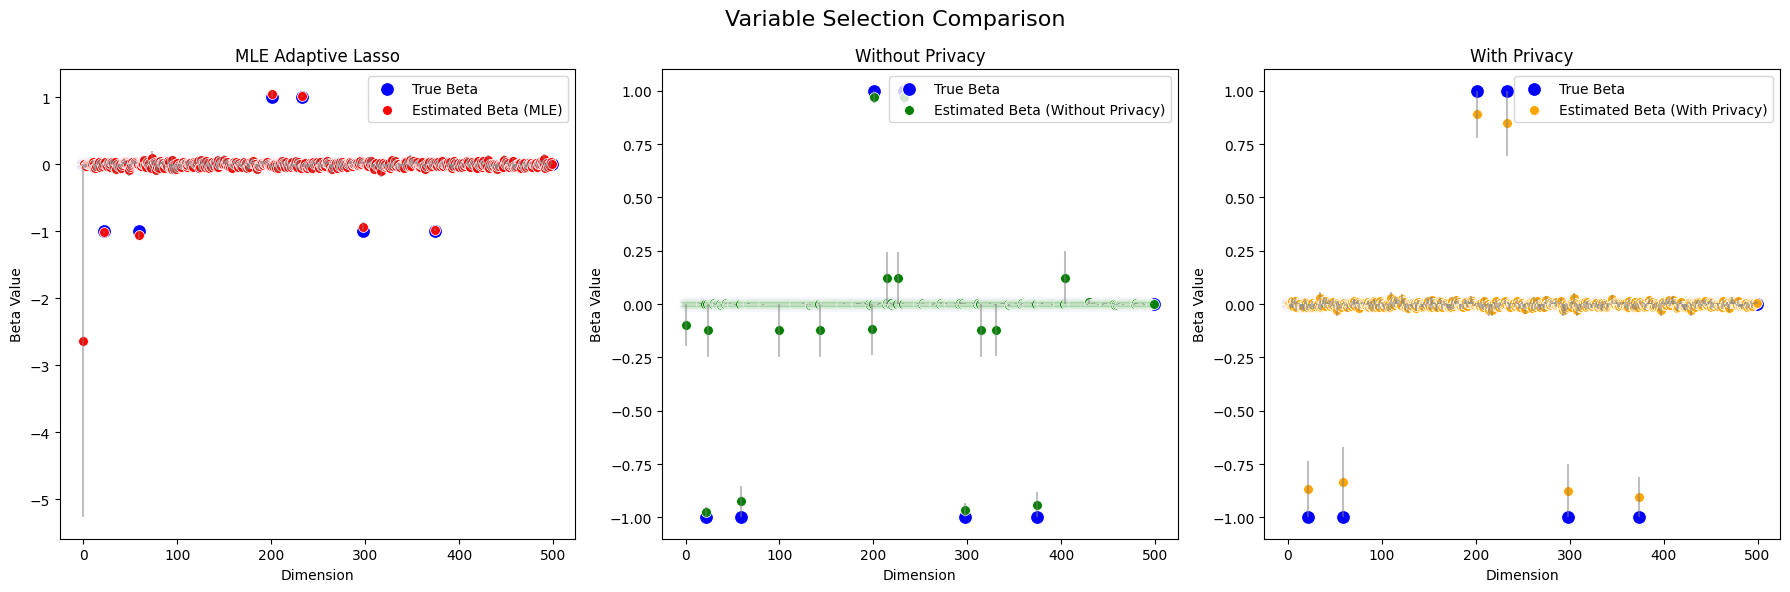

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_variable_selection(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private):
    # 创建一个包含三张子图的图形
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Variable Selection Comparison', fontsize=16)

    # 绘制MLE自适应Lasso方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[0], color='blue', label='True Beta', s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_mle)), y=beta_hat_mle, ax=axes[0], color='red', label='Estimated Beta (MLE)', s=50)
    axes[0].errorbar(np.arange(len(beta_hat_mle)), beta_hat_mle, yerr=np.abs(beta_hat_mle - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[0].set_title('MLE Adaptive Lasso')
    axes[0].set_xlabel('Dimension')
    axes[0].set_ylabel('Beta Value')
    axes[0].legend()

    # 绘制非隐私方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[1], color='blue', label='True Beta', s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_without_private)), y=beta_hat_without_private, ax=axes[1], color='green', label='Estimated Beta (Without Privacy)', s=50)
    axes[1].errorbar(np.arange(len(beta_hat_without_private)), beta_hat_without_private, yerr=np.abs(beta_hat_without_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[1].set_title('Without Privacy')
    axes[1].set_xlabel('Dimension')
    axes[1].set_ylabel('Beta Value')
    axes[1].legend()

    # 绘制隐私方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[2], color='blue', label='True Beta', s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_private)), y=beta_hat_private, ax=axes[2], color='orange', label='Estimated Beta (With Privacy)', s=50)
    axes[2].errorbar(np.arange(len(beta_hat_private)), beta_hat_private, yerr=np.abs(beta_hat_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[2].set_title('With Privacy')
    axes[2].set_xlabel('Dimension')
    axes[2].set_ylabel('Beta Value')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# 从结果中提取估计的beta值
beta_hat_mle = best_results['beta_hat']
beta_hat_without_private = results_without_private['beta_hat']
beta_hat_private = results_private['beta_hat']

# 调用绘图函数
plot_variable_selection(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private)

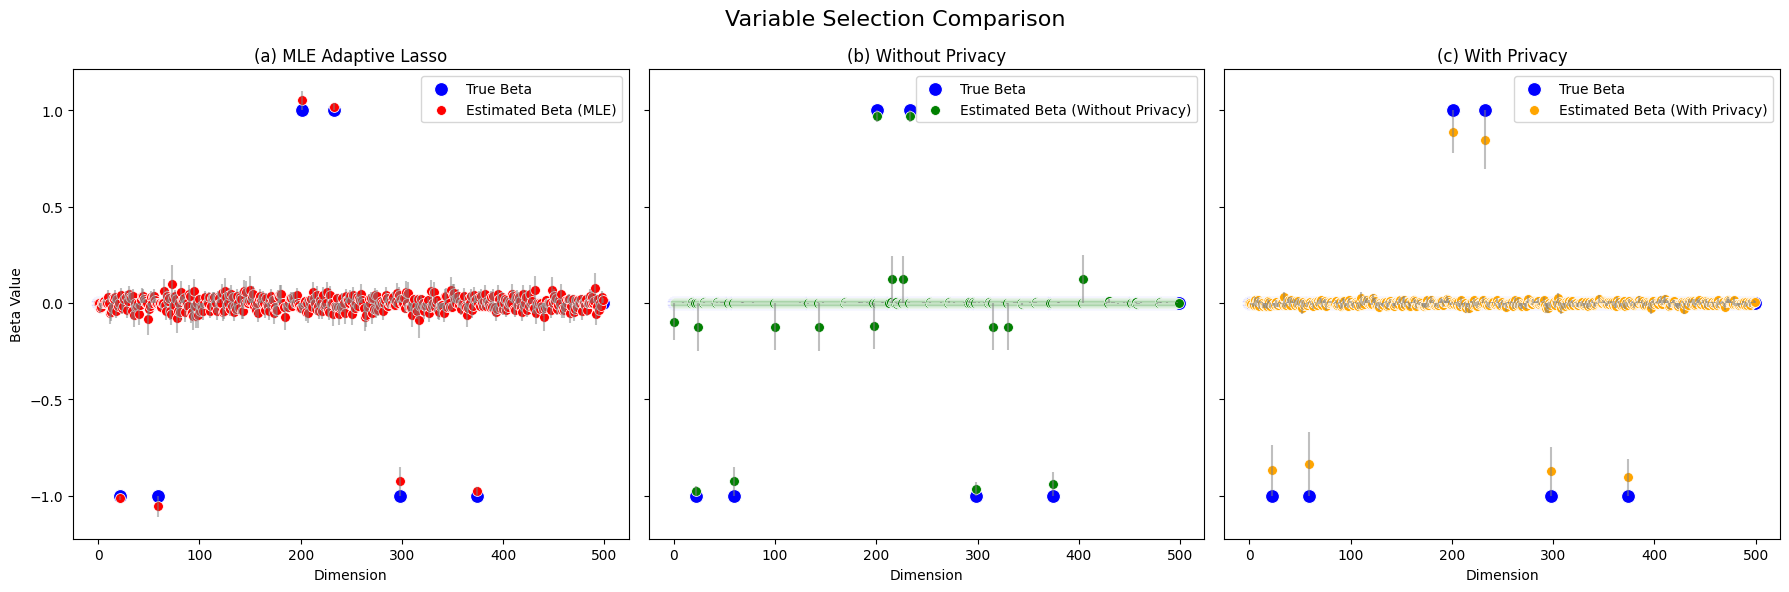

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private):
    # 创建一个包含三张子图的图形
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.suptitle('Variable Selection Comparison', fontsize=16)

    # 定义颜色和标签
    colors = ['blue', 'red', 'green']
    labels = ['True Beta', 'Estimated Beta (MLE)', 'Estimated Beta (Without Privacy)', 'Estimated Beta (With Privacy)']

    # 绘制MLE自适应Lasso方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[0], color=colors[0], label=labels[0], s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_mle)), y=beta_hat_mle, ax=axes[0], color=colors[1], label=labels[1], s=50)
    axes[0].errorbar(np.arange(len(beta_hat_mle)), beta_hat_mle, yerr=np.abs(beta_hat_mle - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[0].set_title('(a) MLE Adaptive Lasso')
    axes[0].set_xlabel('Dimension')
    axes[0].set_ylabel('Beta Value')
    axes[0].legend()

    # 绘制非隐私方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[1], color=colors[0], label=labels[0], s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_without_private)), y=beta_hat_without_private, ax=axes[1], color=colors[2], label=labels[2], s=50)
    axes[1].errorbar(np.arange(len(beta_hat_without_private)), beta_hat_without_private, yerr=np.abs(beta_hat_without_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[1].set_title('(b) Without Privacy')
    axes[1].set_xlabel('Dimension')
    axes[1].legend()

    # 绘制隐私方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[2], color=colors[0], label=labels[0], s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_private)), y=beta_hat_private, ax=axes[2], color='orange', label=labels[3], s=50)
    axes[2].errorbar(np.arange(len(beta_hat_private)), beta_hat_private, yerr=np.abs(beta_hat_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[2].set_title('(c) With Privacy')
    axes[2].set_xlabel('Dimension')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

beta_hat_mle[0] = 0
# 调用绘图函数
plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private)

In [11]:
beta_hat_mle

0    0
Name: beta_hat, dtype: object

In [1]:
import pandas as pd
import ast

# 读取CSV文件
df = pd.read_csv("./results.csv")

# 选择method为'MLE_Adaptive_Lasso'的行
mle_adaptive_lasso_row = df[df['method'] == 'MLE_Adaptive_Lasso']

# 获取beta_hat列的值
beta_hat_str = mle_adaptive_lasso_row['beta_hat'].values[0]

# 将字符串转换为列表
beta_hat_list = ast.literal_eval(beta_hat_str)

# 将小于1e-2的值赋值为0
beta_hat_processed = [0 if abs(x) < 1e-2 else x for x in beta_hat_list]

# 更新DataFrame中的beta_hat列
df.loc[df['method'] == 'MLE_Adaptive_Lasso', 'beta_hat'] = str(beta_hat_processed)

# 保存处理后的DataFrame到新的CSV文件（可选）
df.to_csv('processed_file.csv', index=False)

# 打印处理后的beta_hat
beta_hat_processed

[0,
 0,
 -0.027046363693571936,
 -0.01979937351334114,
 0,
 0,
 0.010567305518493027,
 0,
 0,
 0,
 0.03299585183265219,
 0,
 -0.05489785350967893,
 -0.0463058936405154,
 -0.02772208944196058,
 0.02438705749434112,
 0.01907739279201254,
 0.03288236071858764,
 -0.040086656165166656,
 0.01973897083727062,
 -0.016236122690311394,
 0,
 -1.0104648598390293,
 0.039842476003507835,
 -0.02849283643731713,
 -0.017871731223957767,
 0.019893570998245947,
 0.03170899593408332,
 -0.038674819078265615,
 0.012029461879502839,
 0.043896074345601804,
 0.03250259696140153,
 0.02515310625922605,
 -0.04226800138277761,
 0.03699789600044726,
 -0.06135821446902285,
 0,
 -0.02377930387319823,
 -0.01849736438287651,
 0,
 -0.05716058347208235,
 -0.012822690839731856,
 0.016108594352931067,
 0.037545803933473634,
 0.036482500203840314,
 0.019870577291288886,
 0.010600988344827122,
 0,
 0,
 -0.08397848071234387,
 -0.033736110941492814,
 -0.014614954250301784,
 0.03195749143370584,
 0,
 0.028440078890412064,
 0.03

In [27]:
results_mle=df[df['method'] == 'MLE_Adaptive_Lasso']
# #beta_hat_mle =results_mle['beta_hat']
results_without_private=df[df['method'] == 'without_private']
results_private=df[df['method'] == 'private']

In [28]:
results_mle['beta_hat']

0    [0, 0, -0.027046363693571936, -0.01979937351334114, 0, 0, 0.010567305518493027, 0, 0, 0, 0.03299585183265219, 0, -0.05489785350967893, -0.0463058936405154, -0.02772208944196058, 0.02438705749434112, 0.01907739279201254, 0.03288236071858764, -0.040086656165166656, 0.01973897083727062, -0.016236122690311394, 0, -1.0104648598390293, 0.039842476003507835, -0.02849283643731713, -0.017871731223957767, 0.019893570998245947, 0.03170899593408332, -0.038674819078265615, 0.012029461879502839, 0.043896074345601804, 0.03250259696140153, 0.02515310625922605, -0.04226800138277761, 0.03699789600044726, -0.06135821446902285, 0, -0.02377930387319823, -0.01849736438287651, 0, -0.05716058347208235, -0.012822690839731856, 0.016108594352931067, 0.037545803933473634, 0.036482500203840314, 0.019870577291288886, 0.010600988344827122, 0, 0, -0.08397848071234387, -0.033736110941492814, -0.014614954250301784, 0.03195749143370584, 0, 0.028440078890412064, 0.034958330237636635, 0.01684920851064949, 0, 0, -1.05

In [16]:
# 设置显示选项以防止截断
pd.set_option('display.max_colwidth', None)

# 打印 beta_hat 列的全部内容
print(results_mle['beta_hat'])

0    [0, 0, -0.027046363693571936, -0.01979937351334114, 0, 0, 0.010567305518493027, 0, 0, 0, 0.03299585183265219, 0, -0.05489785350967893, -0.0463058936405154, -0.02772208944196058, 0.02438705749434112, 0.01907739279201254, 0.03288236071858764, -0.040086656165166656, 0.01973897083727062, -0.016236122690311394, 0, -1.0104648598390293, 0.039842476003507835, -0.02849283643731713, -0.017871731223957767, 0.019893570998245947, 0.03170899593408332, -0.038674819078265615, 0.012029461879502839, 0.043896074345601804, 0.03250259696140153, 0.02515310625922605, -0.04226800138277761, 0.03699789600044726, -0.06135821446902285, 0, -0.02377930387319823, -0.01849736438287651, 0, -0.05716058347208235, -0.012822690839731856, 0.016108594352931067, 0.037545803933473634, 0.036482500203840314, 0.019870577291288886, 0.010600988344827122, 0, 0, -0.08397848071234387, -0.033736110941492814, -0.014614954250301784, 0.03195749143370584, 0, 0.028440078890412064, 0.034958330237636635, 0.01684920851064949, 0, 0, -1.05

In [18]:
# 设置显示选项以防止截断
pd.set_option('display.max_colwidth', None)

# 打印 beta_hat 列的全部内容
print(results_without_private['beta_hat'])

1    [-0.09745553  0.          0.          0.          0.          0.\n  0.          0.          0.          0.00118426  0.          0.\n  0.          0.          0.          0.00139953  0.          0.\n  0.0021529   0.          0.          0.         -0.9748815   0.\n -0.1239317   0.          0.          0.          0.          0.\n  0.00312158 -0.00145259  0.          0.          0.          0.\n  0.          0.         -0.00290554  0.          0.          0.\n  0.          0.00344447  0.          0.          0.          0.0019377\n  0.          0.00107666  0.          0.00102278  0.         -0.00123732\n  0.          0.          0.          0.          0.         -0.9253186\n  0.          0.          0.          0.          0.          0.\n  0.          0.00123817  0.00199147  0.          0.          0.\n  0.          0.          0.          0.          0.          0.\n  0.00118424  0.          0.          0.          0.         -0.00134499\n  0.          0.          0.          0. 

In [17]:
results_without_private=df[df['method'] == 'without_private']
results_private=df[df['method'] == 'private']

In [20]:
beta_hat_str = ','.join(map(str, beta_hat_without_private))
print(beta_hat_str)

[-0.09745553  0.          0.          0.          0.          0.
  0.          0.          0.          0.00118426  0.          0.
  0.          0.          0.          0.00139953  0.          0.
  0.0021529   0.          0.          0.         -0.9748815   0.
 -0.1239317   0.          0.          0.          0.          0.
  0.00312158 -0.00145259  0.          0.          0.          0.
  0.          0.         -0.00290554  0.          0.          0.
  0.          0.00344447  0.          0.          0.          0.0019377
  0.          0.00107666  0.          0.00102278  0.         -0.00123732
  0.          0.          0.          0.          0.         -0.9253186
  0.          0.          0.          0.          0.          0.
  0.          0.00123817  0.00199147  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.00118424  0.          0.          0.          0.         -0.00134499
  0.          0.          0.          0.          0.        

In [22]:
print("Type and length of beta_true:")
print(type(beta_true), len(beta_true))

print("\nType and length of beta_hat_mle:")
print(type(beta_hat_mle), len(beta_hat_mle))

print("\nType and length of beta_hat_without_private:")
print(type(beta_hat_without_private), len(beta_hat_without_private))

print("\nType and length of beta_hat_private:")
print(type(beta_hat_private), len(beta_hat_private))


Type and length of beta_true:
<class 'list'> 500

Type and length of beta_hat_mle:
<class 'pandas.core.series.Series'> 1

Type and length of beta_hat_without_private:
<class 'pandas.core.series.Series'> 1

Type and length of beta_hat_private:
<class 'pandas.core.series.Series'> 1


In [23]:
beta_true_series = pd.Series(beta_true)
beta_true_series 

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
495    0.0
496    0.0
497    0.0
498    0.0
499    0.0
Length: 500, dtype: float64

C:\Users\86177\AppData\Local\Temp\ipykernel_31612\4228724202.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beta_hat_mle[0] = 0


ValueError: Length of values (500) does not match length of index (1)

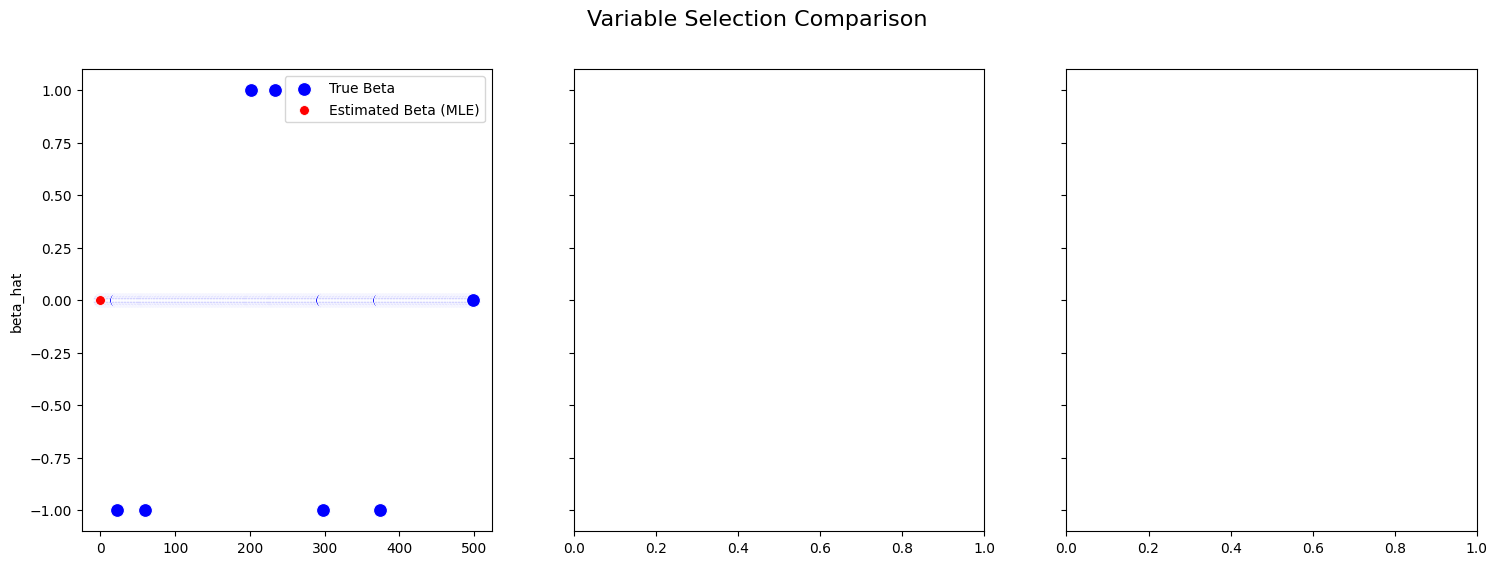

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private):
    # 创建一个包含三张子图的图形
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.suptitle('Variable Selection Comparison', fontsize=16)

    # 定义颜色和标签
    colors = ['blue', 'red', 'green']
    labels = ['True Beta', 'Estimated Beta (MLE)', 'Estimated Beta (Without Privacy)', 'Estimated Beta (With Privacy)']

    # 绘制MLE自适应Lasso方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[0], color=colors[0], label=labels[0], s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_mle)), y=beta_hat_mle, ax=axes[0], color=colors[1], label=labels[1], s=50)
    axes[0].errorbar(np.arange(len(beta_hat_mle)), beta_hat_mle, yerr=np.abs(beta_hat_mle - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[0].set_title('(a) MLE Adaptive Lasso')
    axes[0].set_xlabel('Dimension')
    axes[0].set_ylabel('Beta Value')
    axes[0].legend()

    # 绘制非隐私方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[1], color=colors[0], label=labels[0], s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_without_private)), y=beta_hat_without_private, ax=axes[1], color=colors[2], label=labels[2], s=50)
    axes[1].errorbar(np.arange(len(beta_hat_without_private)), beta_hat_without_private, yerr=np.abs(beta_hat_without_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[1].set_title('(b) Without Privacy')
    axes[1].set_xlabel('Dimension')
    axes[1].legend()

    # 绘制隐私方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[2], color=colors[0], label=labels[0], s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_private)), y=beta_hat_private, ax=axes[2], color='orange', label=labels[3], s=50)
    axes[2].errorbar(np.arange(len(beta_hat_private)), beta_hat_private, yerr=np.abs(beta_hat_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[2].set_title('(c) With Privacy')
    axes[2].set_xlabel('Dimension')
    axes[2].legend()

    plt.tight_layout()
    plt.show()
beta_true=[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.]
# 从结果中提取估计的beta值
beta_hat_mle =results_mle['beta_hat']
beta_hat_without_private = results_without_private['beta_hat']
beta_hat_private = results_private['beta_hat']



beta_hat_mle[0] = 0
# 调用绘图函数
plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private)

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private):
    # 创建一个包含三张子图的图形
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.suptitle('Variable Selection Comparison', fontsize=16)

    # 定义颜色和标签
    colors = ['blue', 'red', 'green']
    labels = ['True Beta', 'Estimated Beta (MLE)', 'Estimated Beta (Without Privacy)', 'Estimated Beta (With Privacy)']

    # 绘制MLE自适应Lasso方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[0], color=colors[0], label=labels[0], s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_mle)), y=beta_hat_mle, ax=axes[0], color=colors[1], label=labels[1], s=50)
    axes[0].errorbar(np.arange(len(beta_hat_mle)), beta_hat_mle, yerr=np.abs(beta_hat_mle - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[0].set_title('(a) MLE Adaptive Lasso')
    axes[0].set_xlabel('Dimension')
    axes[0].set_ylabel('Beta Value')
    axes[0].legend()

    # 绘制非隐私方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[1], color=colors[0], label=labels[0], s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_without_private)), y=beta_hat_without_private, ax=axes[1], color=colors[2], label=labels[2], s=50)
    axes[1].errorbar(np.arange(len(beta_hat_without_private)), beta_hat_without_private, yerr=np.abs(beta_hat_without_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[1].set_title('(b) Without Privacy')
    axes[1].set_xlabel('Dimension')
    axes[1].legend()

    # 绘制隐私方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[2], color=colors[0], label=labels[0], s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_private)), y=beta_hat_private, ax=axes[2], color='orange', label=labels[3], s=50)
    axes[2].errorbar(np.arange(len(beta_hat_private)), beta_hat_private, yerr=np.abs(beta_hat_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[2].set_title('(c) With Privacy')
    axes[2].set_xlabel('Dimension')
    axes[2].legend()

    plt.tight_layout()
    plt.show()
beta_true=[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.]
# 从结果中提取估计的beta值
# beta_hat_mle =results_mle['beta_hat']
# beta_hat_without_private = results_without_private['beta_hat']
# beta_hat_private = results_private['beta_hat']
beta_hat_mle=[0, 0, -0.027046363693571936, -0.01979937351334114, 0, 0, 0.010567305518493027, 0, 0, 0, 0.03299585183265219, 0, -0.05489785350967893, -0.0463058936405154, -0.02772208944196058, 0.02438705749434112, 0.01907739279201254, 0.03288236071858764, -0.040086656165166656, 0.01973897083727062, -0.016236122690311394, 0, -1.0104648598390293, 0.039842476003507835, -0.02849283643731713, -0.017871731223957767, 0.019893570998245947, 0.03170899593408332, -0.038674819078265615, 0.012029461879502839, 0.043896074345601804, 0.03250259696140153, 0.02515310625922605, -0.04226800138277761, 0.03699789600044726, -0.06135821446902285, 0, -0.02377930387319823, -0.01849736438287651, 0, -0.05716058347208235, -0.012822690839731856, 0.016108594352931067, 0.037545803933473634, 0.036482500203840314, 0.019870577291288886, 0.010600988344827122, 0, 0, -0.08397848071234387, -0.033736110941492814, -0.014614954250301784, 0.03195749143370584, 0, 0.028440078890412064, 0.034958330237636635, 0.01684920851064949, 0, 0, -1.0567256248791577, 0, 0, -0.01928475682935271, 0, 0, 0.06265582493353923, -0.013237952955123313, -0.0440076185997374, 0.03457321962284839, 0.010628680468873088, 0.023804366134823042, -0.04375109230346588, -0.05610561647422321, 0.09811858989689971, 0.022971282711060744, -0.010055547407118837, 0.033941560753803265, 0.022651031227218888, -0.07795496463983533, -0.04042186524471049, 0, -0.04657090317876371, 0.05602782583749151, 0.017159487489150773, 0.016251090547604402, 0.024977613778007092, -0.0484302092845429, 0, 0, -0.015448208685514752, 0.04776733687403002, 0.036597698659735806, -0.05174179191579445, -0.04552543311776881, -0.0703443114524177, 0.06164221918963911, -0.014806978661991146, -0.06561853691691033, 0, -0.06454509556971441, 0.0195401604425702, -0.04023368331022266, -0.013919033754734918, -0.01934513396451026, -0.0431092096691197, 0, 0.03160974379967167, 0, 0, 0.028865177189722313, -0.04041788073322753, -0.014389609904019707, 0.023097711972571783, 0.027449934404474997, 0.029196625086222498, -0.02624148152744445, 0, -0.04363512304327307, 0.03188001953750316, 0.026411422696619193, 0, 0, 0.049647978466774934, -0.04631926322104035, -0.0427914221554108, 0.06415898308902704, 0.02889265181165022, -0.01184430701810033, 0, 0.03895013503766866, -0.032805495955851756, 0.04550437803057892, -0.016477915330788795, 0.028753679559610414, -0.048087830520705636, -0.017960559301161628, -0.03051132133334032, 0.0369882489444599, 0, -0.028378107308055206, 0.0300259860859989, 0.018115125047823945, -0.040692575887088196, -0.040756272572303825, 0.05957586118408867, 0, 0.057362674020371866, 0, 0, 0.011788291043024559, 0.0694028828085192, 0.010311201913514211, 0.03136310962252974, 0.043851123946886464, -0.01741891674793989, 0, -0.03457004680925034, 0, -0.050646757335076495, 0.020523870194762983, 0.03579937826924889, 0.011675679098314195, 0, 0.031830522399776684, 0, -0.03900762416000486, 0.025552323368719355, -0.010353412295104957, -0.016895305154452953, -0.04373173880721151, 0.0177018911642029, 0.03582615064147084, 0, 0.0166151027958368, -0.05406029208882979, -0.019623674934825478, -0.037688531398750114, -0.037317465209297976, 0.0338545178000794, 0.028927584156830884, 0.045627468636340776, 0.04655696193473348, 0, 0, -0.021782870137086328, -0.07145485614635008, -0.017210241334211455, -0.022330515812181317, 0, 0.023112418554363003, 0.027494899123139235, -0.014919854186935947, 0.02934446557838024, 0.02793948077537094, 0, 0, 0.0395488724696353, 0, -0.01059979629399617, -0.027242461707361998, -0.027309448242719504, 1.0509322148708655, -0.015307447667181034, 0, 0.010970626439139103, -0.04732730979599735, 0, -0.0534124078905682, 0.014653564198966833, 0, 0.01919181416281682, -0.020194792941178877, 0.054925060272844085, 0.02602996578960133, 0, -0.03220201849940528, 0.04321297345455772, -0.014195082602114965, -0.0408718466483179, 0.015902080553953035, 0, -0.040573169759932026, 0.04054299073925309, -0.01642787356719838, -0.012635273218889109, 0, 0.054511727710953146, -0.03517586706935701, -0.044668690584736596, 0.0428356834251061, 0, 0, -0.059566846950405, 1.0192133960259915, -0.01738541136281095, -0.021069653694282525, 0.024385964791232496, -0.018650897562601198, -0.0568878831418672, -0.028854981366012267, -0.020037235486720546, 0.024450328946692627, -0.02255348653285063, 0, -0.054861226545354594, 0.037358979799049084, 0.012663540533073501, 0.016049127852669483, 0, 0.03388640787433549, 0.012188571268571745, -0.057157314315566164, 0.04202788859581739, -0.016116318775321718, -0.024340161421217952, 0, 0.02901979012041692, -0.015505378692659461, 0.024161042848465333, 0.01752241348676631, 0.04865475773309616, 0.01576343229510886, 0, -0.024014078086285032, -0.07184477240497011, -0.06205202143119902, -0.02261194473162642, 0.022165527857463237, 0, 0.027992060122362893, -0.05423643083610651, 0.02779585094578044, -0.029125731944487962, 0.03976807817435182, -0.03938328561616529, 0.0336173358419828, -0.035180084766113395, 0, -0.015972585965615252, 0.011481032698047207, 0, -0.043693220649066014, 0, 0.016022450798204052, 0.04208056508917044, 0.023676012838827535, -0.01666789414146031, 0, 0, 0.015115110891906617, 0, 0.028783722398660058, -0.010966071365650998, -0.012950167565509863, 0.01107392914050952, 0.05117969484352086, 0, 0.04035876667082476, -0.9268290624301498, 0.021413440620062348, 0, 0, 0.026257186410323936, -0.025013578003342418, 0.056807181207866944, 0, 0.05337658921139719, -0.022650875765482838, -0.019597716498722283, -0.02194400915760476, -0.061919013754203, 0, 0.018068071712708047, -0.02849759416108873, -0.016103173043902855, -0.04278132638008759, 0.01787922613627364, -0.09008401480225588, -0.014750057192304265, 0.02047495785965922, -0.01735143004271627, 0, -0.040740507539562244, -0.01849078940962757, -0.018140850200614386, 0, 0.014752034636966171, -0.05076933206365017, -0.023317247152846977, 0.059507923694708705, -0.015420562012496862, 0, 0.05460931272689589, -0.022817982743233812, 0, 0.012754786068499536, -0.04081500441825941, -0.044595228151871495, -0.015091412429056502, -0.011977296502335406, -0.011943961044397015, -0.019801031849735043, -0.05030900696543696, 0.03634885197111572, 0.03751679551490618, -0.022106400261311, 0, -0.02079536714015022, 0.06833730197713142, -0.019424843171783255, 0.048039933189097786, 0.04961282303714402, 0.02198850943566653, 0, 0.024141081646944805, 0.034987916404671845, -0.012431403485471768, 0.01097112393212256, -0.03255352445236326, 0, 0, 0.037549470487120415, -0.018596270571904935, -0.021790651662240052, -0.06129728670058133, -0.02625043893439877, 0.026907586365202543, 0, 0.036638663047373114, -0.03821224638757724, -0.015609987690164686, 0.04207347455441409, 0.013772625859989892, 0.01836224199938777, -0.977319555177912, 0, 0.030108543901121967, -0.01705206306726072, 0.03502493865212353, 0, -0.017965704086500583, 0.011799411863506484, 0.04704266713068815, -0.015335093037031776, 0.011319722442106337, 0, 0, -0.021857272187983636, 0.030643613619696565, -0.01982533964556664, 0.0356321029265057, -0.03396778798237541, -0.020245262568470788, -0.04718010126594171, -0.029931359822240808, 0.0457526068097756, 0.019148982460358968, -0.026051117357150023, 0, 0.028481579052794415, -0.031221880755134875, 0, 0.018575628216196207, -0.036027329701168044, 0.014707674621669043, -0.019281587767542175, 0, 0.011782902324460953, 0, 0.04849406732542495, 0.0338227864191629, -0.029176750294741198, -0.03686265129190667, 0.018023674191567186, 0.033108320424448445, -0.01266900676953831, 0.02849620659052534, 0.012241198320428354, -0.022432971520309458, -0.046930013317436584, 0.04676765641500269, -0.013823209844946909, 0, 0.03328629025339601, -0.03567686092028066, -0.01392595568469023, 0.045488403179638606, 0, 0.010645879041122647, -0.026145667309401065, -0.0281656390259051, 0.06893304709877532, -0.0548156661149426, 0, -0.015886212278343494, 0, -0.030071344788895577, 0, -0.014301304565890178, -0.03331379850374391, -0.07369325367698856, -0.026874904478912935, 0.013474222406846516, -0.020701066403180375, 0, 0, 0, -0.03907881916361472, 0.0684228325920125, 0, 0.035458704152131995, 0.01218746291516282, 0.02797650579195855, -0.030307364136040175, -0.012182886969237784, 0.014025807107292499, 0, 0.0485971578534186, -0.03797409040392336, -0.027596408014894908, -0.038559235277891256, -0.02136918982109025, 0.013743258804906304, 0, 0.020814894568978025, 0.022286244803848873, -0.05232843413503448, -0.013950155285763727, 0.01598861740839764, 0.020597787094479417, -0.04624849406644124, -0.031336141339766574, 0.012804487492979334, -0.019401416698423202, 0.015022905494251802, 0, 0, 0.021592525723720207, -0.0443984464964149, 0, 0, -0.011575913209983536, 0.021478881780635384, -0.034687421032368944, 0, 0, 0.03583149090682908, 0, 0.031799499978659836, 0, 0.0105607097040455, 0.0781642699285832, -0.05741117314994109, -0.017112016333300256, 0.019873392807084247, -0.03509180680800265, 0, -0.017735344088517693, 0.03041162771775336, 0.013566972640272311]


beta_hat_without_private=[-0.09745553  0.          0.          0.          0.          0.
  0.          0.          0.          0.00118426  0.          0.
  0.          0.          0.          0.00139953  0.          0.
  0.0021529   0.          0.          0.         -0.9748815   0.
 -0.1239317   0.          0.          0.          0.          0.
  0.00312158 -0.00145259  0.          0.          0.          0.
  0.          0.         -0.00290554  0.          0.          0.
  0.          0.00344447  0.          0.          0.          0.0019377
  0.          0.00107666  0.          0.00102278  0.         -0.00123732
  0.          0.          0.          0.          0.         -0.9253186
  0.          0.          0.          0.          0.          0.
  0.          0.00123817  0.00199147  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.00118424  0.          0.          0.          0.         -0.00134499
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.12339357  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.00102284  0.          0.          0.
  0.          0.          0.          0.          0.          0.00145336
  0.          0.          0.         -0.00204454  0.          0.
  0.         -0.00231362  0.          0.          0.          0.
  0.          0.          0.          0.00102285  0.00134569 -0.12393166
  0.          0.          0.          0.00113044  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.0021529   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.00139952  0.00123806  0.
  0.0012919   0.          0.          0.          0.          0.00183001
  0.         -0.00161405  0.          0.         -0.00225983  0.
 -0.11924989  0.          0.          0.9700928   0.          0.
  0.         -0.00112971  0.0013457   0.00177623  0.          0.
  0.          0.          0.          0.          0.0029063   0.1230176
  0.          0.          0.          0.00285245 -0.00338988  0.
  0.00129189  0.00107665  0.          0.00118428  0.12274855  0.00188384
  0.          0.          0.          0.          0.00209904  0.9689623
  0.          0.          0.          0.00102281  0.          0.
  0.          0.          0.          0.          0.          0.
  0.00118428  0.          0.00199145  0.          0.          0.
  0.          0.00247581  0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.00123734
  0.00193765  0.          0.          0.          0.          0.
  0.          0.          0.00473591  0.          0.          0.
  0.          0.00177622  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.00172241
  0.          0.          0.          0.          0.00371345  0.00150713
  0.          0.00258343  0.          0.00172239 -0.96535647  0.
  0.          0.00118425  0.          0.          0.          0.
  0.00156096  0.          0.          0.          0.          0.0041978
  0.          0.          0.         -0.12339348  0.          0.
  0.          0.          0.          0.          0.          0.
  0.00188385  0.          0.          0.          0.         -0.00193696
 -0.12280163  0.          0.          0.          0.          0.
  0.00123807  0.          0.00204529  0.          0.          0.
  0.         -0.00102209 -0.00478902  0.          0.          0.
  0.          0.          0.          0.          0.00129188  0.
  0.          0.          0.00118427 -0.00112972  0.00349824  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.00139951  0.          0.
  0.          0.         -0.9400106   0.          0.          0.
  0.          0.00166859  0.00150714  0.          0.          0.
  0.          0.00102283  0.          0.          0.          0.
 -0.00139876  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.12334049  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.00166782  0.00107662  0.          0.00931015  0.
  0.          0.00166858  0.          0.00139958  0.          0.
  0.         -0.00220592  0.          0.          0.          0.
 -0.00112972  0.00129193  0.          0.          0.00145331  0.
  0.          0.          0.          0.          0.          0.
  0.00236814 -0.00322843  0.         -0.00252887  0.          0.00134569
  0.          0.          0.          0.         -0.00112973  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.00204454  0.0012381   0.
  0.00301393  0.0012919   0.          0.          0.          0.
  0.          0.00177621 -0.00145257  0.          0.          0.
  0.          0.          0.          0.          0.          0.00123808
  0.          0.        ]

beta_hat_private=[ 0.          0.         -0.00534677 -0.00991252 -0.008526    0.01503309
 -0.00931494  0.0076201   0.01405665 -0.01568903  0.00418309  0.
  0.00187875 -0.01424392 -0.00747146 -0.01255667 -0.01366978 -0.01613426
  0.01071731  0.00385501 -0.01348619  0.         -0.8687376  -0.00834242
 -0.00478435 -0.0127871   0.00712405 -0.01180677 -0.01057649  0.00108979
  0.00158972 -0.00198006  0.         -0.01184581  0.0282421  -0.01282616
 -0.00825651  0.00130851  0.01034236  0.01555253 -0.00968208  0.01486903
  0.00584301  0.00354255  0.00974087 -0.00945555  0.00774897 -0.00455001
  0.01152582 -0.00863143  0.          0.00652261 -0.02813643  0.00657336
 -0.01149432 -0.0018629   0.         -0.01159976  0.00133195 -0.83614033
  0.00545243 -0.00506947  0.00105073 -0.01579841  0.          0.00332774
  0.         -0.00869393  0.0079794  -0.00166371  0.01249438  0.01281854
 -0.01141621  0.00453851  0.00716703  0.01008848 -0.01721613  0.00342539
  0.00104683  0.00463616  0.          0.00460491  0.         -0.00284322
  0.0017186   0.00776851 -0.01219735 -0.00401493  0.00366366  0.00660852
 -0.01598585 -0.01218954  0.0124983   0.01020174 -0.0118302  -0.00676845
 -0.00149186 -0.01347839  0.01267405  0.          0.00367926 -0.00702231
 -0.01287695  0.00112494  0.          0.00234743 -0.00171451 -0.01587258
  0.00237476 -0.01338077  0.02748831 -0.00890486  0.00529621 -0.00667861
  0.01682579  0.0083075   0.01361924  0.          0.00842857 -0.00655364
  0.         -0.00536239  0.02312957  0.0125686   0.0116234  -0.01321281
 -0.00902592  0.00189436 -0.01879794  0.00122648 -0.00438987 -0.00763159
 -0.01090457  0.00271065  0.00105464  0.00533137 -0.01628268 -0.0113498
  0.00305434  0.00927609  0.          0.         -0.007987   -0.01447434
 -0.00733087  0.00497204 -0.00112083 -0.00661611  0.01138906  0.01606417
 -0.00231596 -0.01438061  0.01610323  0.01689219 -0.01168568  0.00299577
  0.00523762  0.00270674 -0.01521644 -0.01428297  0.00364022  0.00277314
  0.01310757  0.0083778  -0.01462276 -0.00161293  0.00650307 -0.00532331
  0.00332776 -0.00137079 -0.00916264 -0.00958835 -0.01355652 -0.00964302
 -0.01338857  0.0154002  -0.01105688  0.          0.00710845  0.01752101
  0.00121086  0.00716703  0.00105073 -0.01090846 -0.00786984  0.
 -0.01233012  0.00107417  0.00426903  0.01145548  0.00977603 -0.00947897
  0.00667491  0.00538214  0.00591329  0.0180092   0.01267014  0.00412451
 -0.00498745 -0.00565923  0.00138273  0.88938767 -0.00663564  0.002199
  0.00185921 -0.00905716  0.0055657  -0.0115451  -0.01453683  0.01472062
 -0.0058311  -0.01094752 -0.00315568  0.00135929 -0.02730061 -0.0112678
 -0.00653018 -0.0269608   0.          0.00375346  0.0049525  -0.01149823
  0.01252173 -0.00872127  0.00171861 -0.01418922  0.00412842 -0.00575686
  0.          0.          0.00319885  0.0143574   0.          0.84733015
  0.00482365 -0.01066632  0.00124992 -0.01231843  0.00327697  0.00100386
  0.00328089  0.00332775 -0.00758863  0.          0.01280684  0.00139834
 -0.01192395 -0.01227545  0.0028239   0.00672961 -0.01116623 -0.00611228
 -0.00198396 -0.02225056  0.00146082  0.00126945  0.00128117 -0.00672938
  0.00480408  0.002324   -0.01641547  0.00312074  0.01604855 -0.01327921
  0.          0.01187338 -0.01048665 -0.00682704 -0.01493522 -0.01471258
  0.         -0.00488199 -0.00989299 -0.01598193  0.00428073  0.01775925
  0.          0.          0.         -0.00622944  0.0089246   0.0024021
  0.00565553  0.00212089  0.00382377  0.01155312 -0.00625287  0.
  0.          0.00553446  0.          0.01450191 -0.00896735 -0.0270936
 -0.01517345 -0.02498846  0.00202718 -0.01292771 -0.8741305   0.
  0.          0.0041909  -0.01253713  0.0061828   0.00180454  0.02592603
 -0.00673329  0.00259347 -0.02854653  0.         -0.01555232 -0.00428443
 -0.01351746  0.00296843  0.         -0.00849476  0.00739747 -0.01160758
  0.00394093  0.00805752 -0.01108813  0.00182796 -0.0012419  -0.01005313
 -0.00995548  0.0018553   0.00174203 -0.00685439  0.00614373 -0.00894391
 -0.01227936 -0.00551081  0.00449164 -0.01310735 -0.0160249   0.00637027
 -0.01009607 -0.00129659  0.00697175  0.00225369 -0.01283788 -0.00813153
  0.00250756 -0.00281587  0.          0.02128603  0.          0.00163659
  0.          0.00861994  0.00581957  0.00183967 -0.00806903 -0.00793233
  0.00368708 -0.00329629  0.00518685  0.0014374   0.00555007 -0.00824871
  0.0057063  -0.01270897 -0.01407988  0.01418553  0.          0.00476113
 -0.01153727 -0.00826431  0.         -0.01301362  0.0078349  -0.01476727
  0.0021209  -0.01164274 -0.9048604   0.01001426  0.         -0.00710433
  0.00367926  0.00175767 -0.01322452 -0.00785813  0.00166782  0.00421434
  0.          0.01755223  0.00263254  0.00265987  0.00876446 -0.01232624
 -0.0083268   0.00344492 -0.00843616  0.00513217  0.         -0.01663028
  0.00142958 -0.02811691  0.00501892  0.01124065 -0.00455781  0.00179672
  0.00524935 -0.0031674   0.01097898  0.00779976  0.0166969  -0.00485076
  0.00778413  0.01460346  0.01946601  0.0027497   0.00631558  0.00378081
 -0.01690367 -0.01190831  0.00286298  0.00286688  0.00745994  0.00864731
 -0.00765893 -0.01034996 -0.01290818 -0.01493131 -0.00718244 -0.01314641
  0.00100777  0.00383938  0.         -0.02913631 -0.00474922  0.00400345
  0.         -0.01261915  0.01049076  0.00483924  0.          0.0099596
 -0.005503    0.01022909 -0.01004923 -0.00525694  0.0091394   0.00775287
  0.01252563 -0.00473358 -0.00313615  0.00358161  0.00795205  0.
 -0.01237699  0.01111569  0.00455413 -0.00968988  0.00214432  0.
  0.00141786  0.00224978 -0.01122484  0.0013007   0.00235914  0.
 -0.01215438  0.01258032 -0.00590529  0.0011015  -0.00402666  0.0039839
  0.00276922 -0.01098268 -0.0191885   0.00465959  0.0096823   0.01598606
  0.01120552  0.00636637  0.00380424  0.00114448 -0.00514758  0.01445505
 -0.00672157 -0.00797139 -0.00478436 -0.01132637 -0.00583497  0.
 -0.00547176  0.00585472  0.00469474 -0.01183021  0.00228883 -0.0086002
  0.          0.00664368 -0.00957663  0.00289031  0.00301529  0.
  0.0069366   0.00454631]


beta_hat_mle[0] = 0
# 调用绘图函数
plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1455663643.py, line 84)

In [25]:
beta_true

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

In [26]:
beta_hat_mle

0    0
Name: beta_hat, dtype: object

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private):
    # 创建一个包含三张子图的图形
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.suptitle('Variable Selection Comparison', fontsize=16)

    # 定义颜色和标签
    colors = ['blue', 'red', 'green']
    labels = ['True Beta', 'Estimated Beta (MLE)', 'Estimated Beta (Without Privacy)', 'Estimated Beta (With Privacy)']

    # 将 pandas.Series 转换为 NumPy 数组
    beta_hat_mle = np.array(beta_hat_mle)
    beta_hat_without_private = np.array(beta_hat_without_private)
    beta_hat_private = np.array(beta_hat_private)

    # 绘制MLE自适应Lasso方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[0], color=colors[0], label=labels[0], s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_mle)), y=beta_hat_mle, ax=axes[0], color=colors[1], label=labels[1], s=50)
    axes[0].errorbar(np.arange(len(beta_hat_mle)), beta_hat_mle, yerr=np.abs(beta_hat_mle - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[0].set_title('(a) MLE Adaptive Lasso')
    axes[0].set_xlabel('Dimension')
    axes[0].set_ylabel('Beta Value')
    axes[0].legend()

    # 绘制非隐私方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[1], color=colors[0], label=labels[0], s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_without_private)), y=beta_hat_without_private, ax=axes[1], color=colors[2], label=labels[2], s=50)
    axes[1].errorbar(np.arange(len(beta_hat_without_private)), beta_hat_without_private, yerr=np.abs(beta_hat_without_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[1].set_title('(b) Without Privacy')
    axes[1].set_xlabel('Dimension')
    axes[1].legend()

    # 绘制隐私方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[2], color=colors[0], label=labels[0], s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_private)), y=beta_hat_private, ax=axes[2], color='orange', label=labels[3], s=50)
    axes[2].errorbar(np.arange(len(beta_hat_private)), beta_hat_private, yerr=np.abs(beta_hat_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[2].set_title('(c) With Privacy')
    axes[2].set_xlabel('Dimension')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# # 示例数据
# beta_true = [0.] * 500  # 这里用你的实际数据
# beta_hat_mle = pd.Series([-0.09745553] + [0.] * 499)  # 这里用你的实际数据
# beta_hat_without_private = pd.Series([0.] * 500)  # 这里用你的实际数据
# beta_hat_private = pd.Series([0.] * 500)  # 这里用你的实际数据
beta_hat_mle = results_mle['beta_hat']
beta_hat_without_private = results_without_private['beta_hat']
beta_hat_private = results_private['beta_hat']
# 调用绘图函数
plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private)

TypeError: unsupported operand type(s) for -: 'str' and 'float'

ValueError: Image size of 73118x565 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1800x600 with 3 Axes>

In [11]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
import optuna
import statsmodels.api as sm
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import Ridge
import logging
import math


# 保存数据和参数
data_dir = "data"

# 加载数据
x = np.load(os.path.join(data_dir, "x.npy"))
y = np.load(os.path.join(data_dir, "y.npy"))
beta_true = np.load(os.path.join(data_dir, "beta_true.npy"))
sigma_u = np.load(os.path.join(data_dir, "sigma_u.npy"))
sigma_v = np.load(os.path.join(data_dir, "sigma_v.npy"))



In [12]:
import pandas as pd
import ast

# 读取CSV文件
df = pd.read_csv("./results.csv")

# 选择method为'MLE_Adaptive_Lasso'的行
mle_adaptive_lasso_row = df[df['method'] == 'MLE_Adaptive_Lasso']


In [14]:
a=mle_adaptive_lasso_row['beta_hat']
a=pd.Series(a)

In [10]:
type(a)

pandas.core.series.Series

In [7]:
threshold = 1e-1

# Processing the list
processed_a = [0 if abs(x) < threshold else x for x in a]
processed_a

TypeError: bad operand type for abs(): 'str'

In [15]:
results_mle=df[df['method'] == 'MLE_Adaptive_Lasso']
# #beta_hat_mle =results_mle['beta_hat']
results_without_private=df[df['method'] == 'without_private']
results_private=df[df['method'] == 'private']
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private):
    # 创建一个包含三张子图的图形
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.suptitle('Variable Selection Comparison', fontsize=16)

    # 定义颜色和标签
    colors = ['blue', 'red', 'green']
    labels = ['True Beta', 'Estimated Beta (MLE)', 'Estimated Beta (Without Privacy)', 'Estimated Beta (With Privacy)']

    # 将 pandas.Series 转换为 NumPy 数组
    beta_hat_mle = np.array(beta_hat_mle)
    beta_hat_without_private = np.array(beta_hat_without_private)
    beta_hat_private = np.array(beta_hat_private)

    # 绘制MLE自适应Lasso方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[0], color=colors[0], label=labels[0], s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_mle)), y=beta_hat_mle, ax=axes[0], color=colors[1], label=labels[1], s=50)
    axes[0].errorbar(np.arange(len(beta_hat_mle)), beta_hat_mle, yerr=np.abs(beta_hat_mle - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[0].set_title('(a) MLE Adaptive Lasso')
    axes[0].set_xlabel('Dimension')
    axes[0].set_ylabel('Beta Value')
    axes[0].legend()

    # 绘制非隐私方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[1], color=colors[0], label=labels[0], s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_without_private)), y=beta_hat_without_private, ax=axes[1], color=colors[2], label=labels[2], s=50)
    axes[1].errorbar(np.arange(len(beta_hat_without_private)), beta_hat_without_private, yerr=np.abs(beta_hat_without_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[1].set_title('(b) Without Privacy')
    axes[1].set_xlabel('Dimension')
    axes[1].legend()

    # 绘制隐私方法的变量选择效果
    sns.scatterplot(x=np.arange(len(beta_true)), y=beta_true, ax=axes[2], color=colors[0], label=labels[0], s=100)
    sns.scatterplot(x=np.arange(len(beta_hat_private)), y=beta_hat_private, ax=axes[2], color='orange', label=labels[3], s=50)
    axes[2].errorbar(np.arange(len(beta_hat_private)), beta_hat_private, yerr=np.abs(beta_hat_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[2].set_title('(c) With Privacy')
    axes[2].set_xlabel('Dimension')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# # 示例数据
# beta_true = [0.] * 500  # 这里用你的实际数据
# beta_hat_mle = pd.Series([-0.09745553] + [0.] * 499)  # 这里用你的实际数据
# beta_hat_without_private = pd.Series([0.] * 500)  # 这里用你的实际数据
# beta_hat_private = pd.Series([0.] * 500)  # 这里用你的实际数据
beta_hat_mle = results_mle['beta_hat']
beta_hat_without_private = results_without_private['beta_hat']
beta_hat_private = results_private['beta_hat']
# 调用绘图函数
plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private)

TypeError: unsupported operand type(s) for -: 'str' and 'float'

ValueError: Image size of 74523x565 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1800x600 with 3 Axes>

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 加载真实参数
beta_true = np.load("data/beta_true.npy")

# 加载结果文件（假设结果保存在 CSV 中）
results_df = pd.read_csv("results.csv")

# 提取各方法的 beta_hat 值（注意转换列表字符串为数组）
def parse_beta(beta_str):
    return np.array([float(x) for x in beta_str.strip("[]").split(", ")])

beta_hat_mle = parse_beta(results_df.iloc[0]["beta_hat"])
beta_hat_without_private = parse_beta(results_df.iloc[1]["beta_hat"])
beta_hat_private = parse_beta(results_df.iloc[2]["beta_hat"])

ValueError: could not convert string to float: '-0.09745553  0.          0.          0.          0.          0.\n  0.          0.          0.          0.00118426  0.          0.\n  0.          0.          0.          0.00139953  0.          0.\n  0.0021529   0.          0.          0.         -0.9748815   0.\n -0.1239317   0.          0.          0.          0.          0.\n  0.00312158 -0.00145259  0.          0.          0.          0.\n  0.          0.         -0.00290554  0.          0.          0.\n  0.          0.00344447  0.          0.          0.          0.0019377\n  0.          0.00107666  0.          0.00102278  0.         -0.00123732\n  0.          0.          0.          0.          0.         -0.9253186\n  0.          0.          0.          0.          0.          0.\n  0.          0.00123817  0.00199147  0.          0.          0.\n  0.          0.          0.          0.          0.          0.\n  0.00118424  0.          0.          0.          0.         -0.00134499\n  0.          0.          0.          0.          0.          0.\n  0.          0.          0.          0.          0.          0.\n  0.          0.          0.          0.         -0.12339357  0.\n  0.          0.          0.          0.          0.          0.\n  0.          0.          0.          0.          0.          0.\n  0.          0.          0.00102284  0.          0.          0.\n  0.          0.          0.          0.          0.          0.00145336\n  0.          0.          0.         -0.00204454  0.          0.\n  0.         -0.00231362  0.          0.          0.          0.\n  0.          0.          0.          0.00102285  0.00134569 -0.12393166\n  0.          0.          0.          0.00113044  0.          0.\n  0.          0.          0.          0.          0.          0.\n  0.          0.          0.          0.          0.          0.\n  0.          0.          0.          0.          0.          0.\n  0.          0.0021529   0.          0.          0.          0.\n  0.          0.          0.          0.          0.          0.\n  0.          0.          0.          0.00139952  0.00123806  0.\n  0.0012919   0.          0.          0.          0.          0.00183001\n  0.         -0.00161405  0.          0.         -0.00225983  0.\n -0.11924989  0.          0.          0.9700928   0.          0.\n  0.         -0.00112971  0.0013457   0.00177623  0.          0.\n  0.          0.          0.          0.          0.0029063   0.1230176\n  0.          0.          0.          0.00285245 -0.00338988  0.\n  0.00129189  0.00107665  0.          0.00118428  0.12274855  0.00188384\n  0.          0.          0.          0.          0.00209904  0.9689623\n  0.          0.          0.          0.00102281  0.          0.\n  0.          0.          0.          0.          0.          0.\n  0.00118428  0.          0.00199145  0.          0.          0.\n  0.          0.00247581  0.          0.          0.          0.\n  0.          0.          0.          0.          0.         -0.00123734\n  0.00193765  0.          0.          0.          0.          0.\n  0.          0.          0.00473591  0.          0.          0.\n  0.          0.00177622  0.          0.          0.          0.\n  0.          0.          0.          0.          0.          0.00172241\n  0.          0.          0.          0.          0.00371345  0.00150713\n  0.          0.00258343  0.          0.00172239 -0.96535647  0.\n  0.          0.00118425  0.          0.          0.          0.\n  0.00156096  0.          0.          0.          0.          0.0041978\n  0.          0.          0.         -0.12339348  0.          0.\n  0.          0.          0.          0.          0.          0.\n  0.00188385  0.          0.          0.          0.         -0.00193696\n -0.12280163  0.          0.          0.          0.          0.\n  0.00123807  0.          0.00204529  0.          0.          0.\n  0.         -0.00102209 -0.00478902  0.          0.          0.\n  0.          0.          0.          0.          0.00129188  0.\n  0.          0.          0.00118427 -0.00112972  0.00349824  0.\n  0.          0.          0.          0.          0.          0.\n  0.          0.          0.          0.00139951  0.          0.\n  0.          0.         -0.9400106   0.          0.          0.\n  0.          0.00166859  0.00150714  0.          0.          0.\n  0.          0.00102283  0.          0.          0.          0.\n -0.00139876  0.          0.          0.          0.          0.\n  0.          0.          0.          0.          0.          0.\n  0.          0.          0.12334049  0.          0.          0.\n  0.          0.          0.          0.          0.          0.\n  0.          0.          0.          0.          0.          0.\n  0.          0.          0.          0.          0.          0.\n  0.         -0.00166782  0.00107662  0.          0.00931015  0.\n  0.          0.00166858  0.          0.00139958  0.          0.\n  0.         -0.00220592  0.          0.          0.          0.\n -0.00112972  0.00129193  0.          0.          0.00145331  0.\n  0.          0.          0.          0.          0.          0.\n  0.00236814 -0.00322843  0.         -0.00252887  0.          0.00134569\n  0.          0.          0.          0.         -0.00112973  0.\n  0.          0.          0.          0.          0.          0.\n  0.          0.          0.         -0.00204454  0.0012381   0.\n  0.00301393  0.0012919   0.          0.          0.          0.\n  0.          0.00177621 -0.00145257  0.          0.          0.\n  0.          0.          0.          0.          0.          0.00123808\n  0.          0.        '

beta_true shape: (500,)
beta_hat_mle shape: (500,)
beta_hat_without_private shape: (500,)
beta_hat_private shape: (500,)


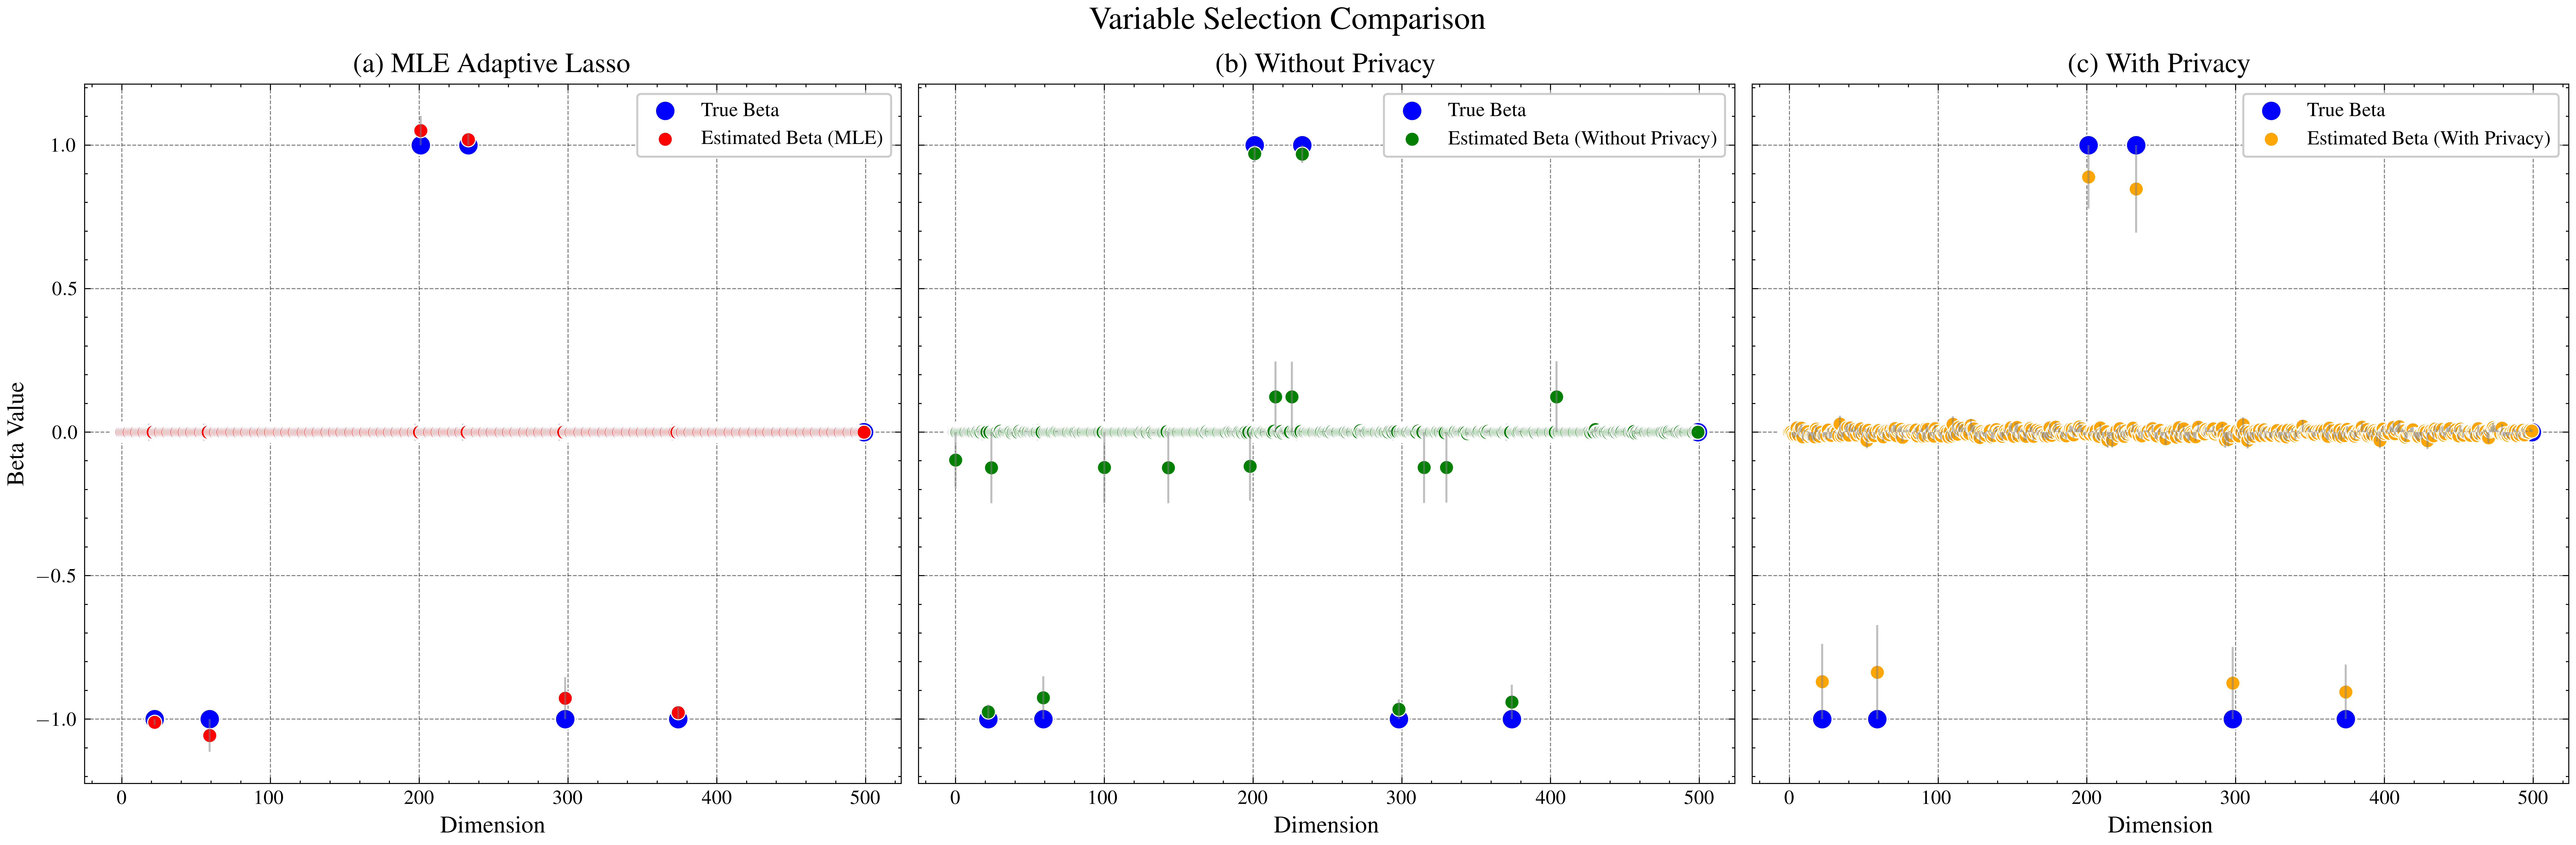

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 自定义解析函数
# -------------------------------
def parse_beta_hat(beta_str):
    """
    将保存的字符串形式的 beta_hat 转换为 numpy 数组
    """
    beta_str = beta_str.strip("[]").strip()
    beta_str = beta_str.replace(",", " ")  # 替换逗号为单个空格
    parts = beta_str.split()
    beta_array = np.array([float(x) for x in parts])
    return beta_array

# -------------------------------
# 加载保存的结果
# -------------------------------
results_df = pd.read_csv("results.csv")

# 假设 CSV 的行顺序为：
# 第1行：MLE Adaptive Lasso 结果
# 第2行：Without Privacy 结果
# 第3行：With Privacy 结果

beta_hat_mle = parse_beta_hat(results_df.iloc[0]['beta_hat'])
beta_hat_without_private = parse_beta_hat(results_df.iloc[1]['beta_hat'])
beta_hat_private = parse_beta_hat(results_df.iloc[2]['beta_hat'])

# 加载真实的 beta 参数（假设保存在 data/beta_true.npy）
beta_true = np.load("data/beta_true.npy")

# 打印形状检查（调试用）
print("beta_true shape:", beta_true.shape)
print("beta_hat_mle shape:", beta_hat_mle.shape)
print("beta_hat_without_private shape:", beta_hat_without_private.shape)
print("beta_hat_private shape:", beta_hat_private.shape)

# -------------------------------
# 对 beta_hat_mle 进行阈值处理：将每个元素绝对值小于 1e-1 的赋值为 0
# -------------------------------
beta_hat_mle[np.abs(beta_hat_mle) < 1e-1] = 0

# -------------------------------
# 绘图函数
# -------------------------------
def plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private):
    # 创建包含三个子图的画布
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.suptitle('Variable Selection Comparison', fontsize=16)
    
    # 定义颜色和标签
    true_color = 'blue'
    mle_color = 'red'
    without_private_color = 'green'
    with_private_color = 'orange'
    
    label_true = 'True Beta'
    label_mle = 'Estimated Beta (MLE)'
    label_without_private = 'Estimated Beta (Without Privacy)'
    label_with_private = 'Estimated Beta (With Privacy)'
    
    indices = np.arange(len(beta_true))
    
    # (a) MLE Adaptive Lasso 的结果
    sns.scatterplot(x=indices, y=beta_true, ax=axes[0],
                    color=true_color, label=label_true, s=100)
    sns.scatterplot(x=indices, y=beta_hat_mle, ax=axes[0],
                    color=mle_color, label=label_mle, s=50)
    axes[0].errorbar(indices, beta_hat_mle,
                     yerr=np.abs(beta_hat_mle - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[0].set_title('(a) MLE Adaptive Lasso')
    axes[0].set_xlabel('Dimension')
    axes[0].set_ylabel('Beta Value')
    axes[0].legend()
    
    # (b) Without Privacy 的结果
    sns.scatterplot(x=indices, y=beta_true, ax=axes[1],
                    color=true_color, label=label_true, s=100)
    sns.scatterplot(x=indices, y=beta_hat_without_private, ax=axes[1],
                    color=without_private_color, label=label_without_private, s=50)
    axes[1].errorbar(indices, beta_hat_without_private,
                     yerr=np.abs(beta_hat_without_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[1].set_title('(b) Without Privacy')
    axes[1].set_xlabel('Dimension')
    axes[1].legend()
    
    # (c) With Privacy 的结果
    sns.scatterplot(x=indices, y=beta_true, ax=axes[2],
                    color=true_color, label=label_true, s=100)
    sns.scatterplot(x=indices, y=beta_hat_private, ax=axes[2],
                    color=with_private_color, label=label_with_private, s=50)
    axes[2].errorbar(indices, beta_hat_private,
                     yerr=np.abs(beta_hat_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[2].set_title('(c) With Privacy')
    axes[2].set_xlabel('Dimension')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

# -------------------------------
# 调用绘图函数进行可视化
# -------------------------------
plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private)


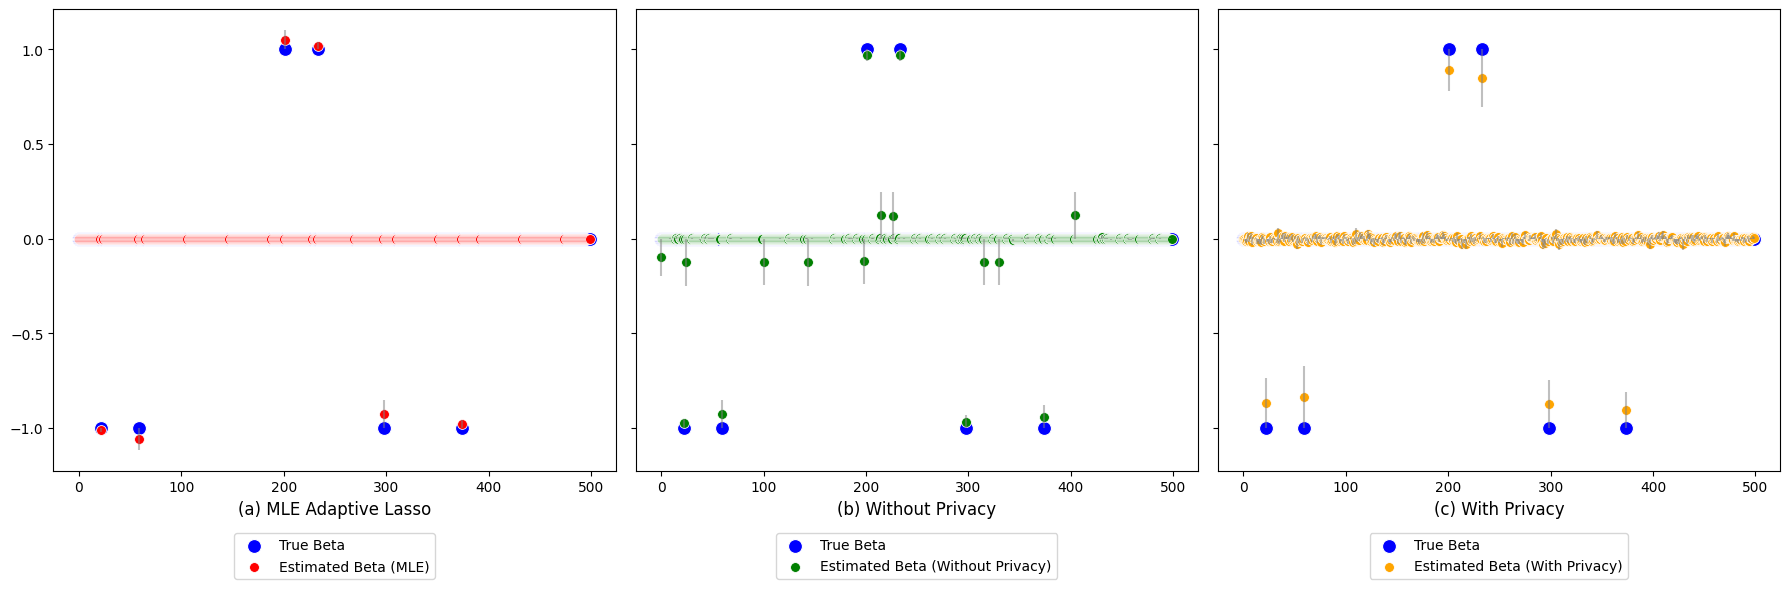

In [20]:
def plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private):
    # 创建包含三个子图的画布
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # 定义颜色和标签
    true_color = 'blue'
    mle_color = 'red'
    without_private_color = 'green'
    with_private_color = 'orange'
    
    label_true = 'True Beta'
    label_mle = 'Estimated Beta (MLE)'
    label_without_private = 'Estimated Beta (Without Privacy)'
    label_with_private = 'Estimated Beta (With Privacy)'
    
    indices = np.arange(len(beta_true))
    
    # (a) MLE Adaptive Lasso 的结果
    sns.scatterplot(x=indices, y=beta_true, ax=axes[0],
                    color=true_color, label=label_true, s=100)
    sns.scatterplot(x=indices, y=beta_hat_mle, ax=axes[0],
                    color=mle_color, label=label_mle, s=50)
    axes[0].errorbar(indices, beta_hat_mle,
                     yerr=np.abs(beta_hat_mle - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[0].set_xlabel('(a) MLE Adaptive Lasso', fontsize=12)  # 设置标题到下方
    axes[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.25))  # 将图例放到下方
    
    # (b) Without Privacy 的结果
    sns.scatterplot(x=indices, y=beta_true, ax=axes[1],
                    color=true_color, label=label_true, s=100)
    sns.scatterplot(x=indices, y=beta_hat_without_private, ax=axes[1],
                    color=without_private_color, label=label_without_private, s=50)
    axes[1].errorbar(indices, beta_hat_without_private,
                     yerr=np.abs(beta_hat_without_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[1].set_xlabel('(b) Without Privacy', fontsize=12)
    axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.25))
    
    # (c) With Privacy 的结果
    sns.scatterplot(x=indices, y=beta_true, ax=axes[2],
                    color=true_color, label=label_true, s=100)
    sns.scatterplot(x=indices, y=beta_hat_private, ax=axes[2],
                    color=with_private_color, label=label_with_private, s=50)
    axes[2].errorbar(indices, beta_hat_private,
                     yerr=np.abs(beta_hat_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[2].set_xlabel('(c) With Privacy', fontsize=12)
    axes[2].legend(loc='lower center', bbox_to_anchor=(0.5, -0.25))
    
    # 调整整体布局，防止重叠
    plt.tight_layout()
    plt.show()
plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private)

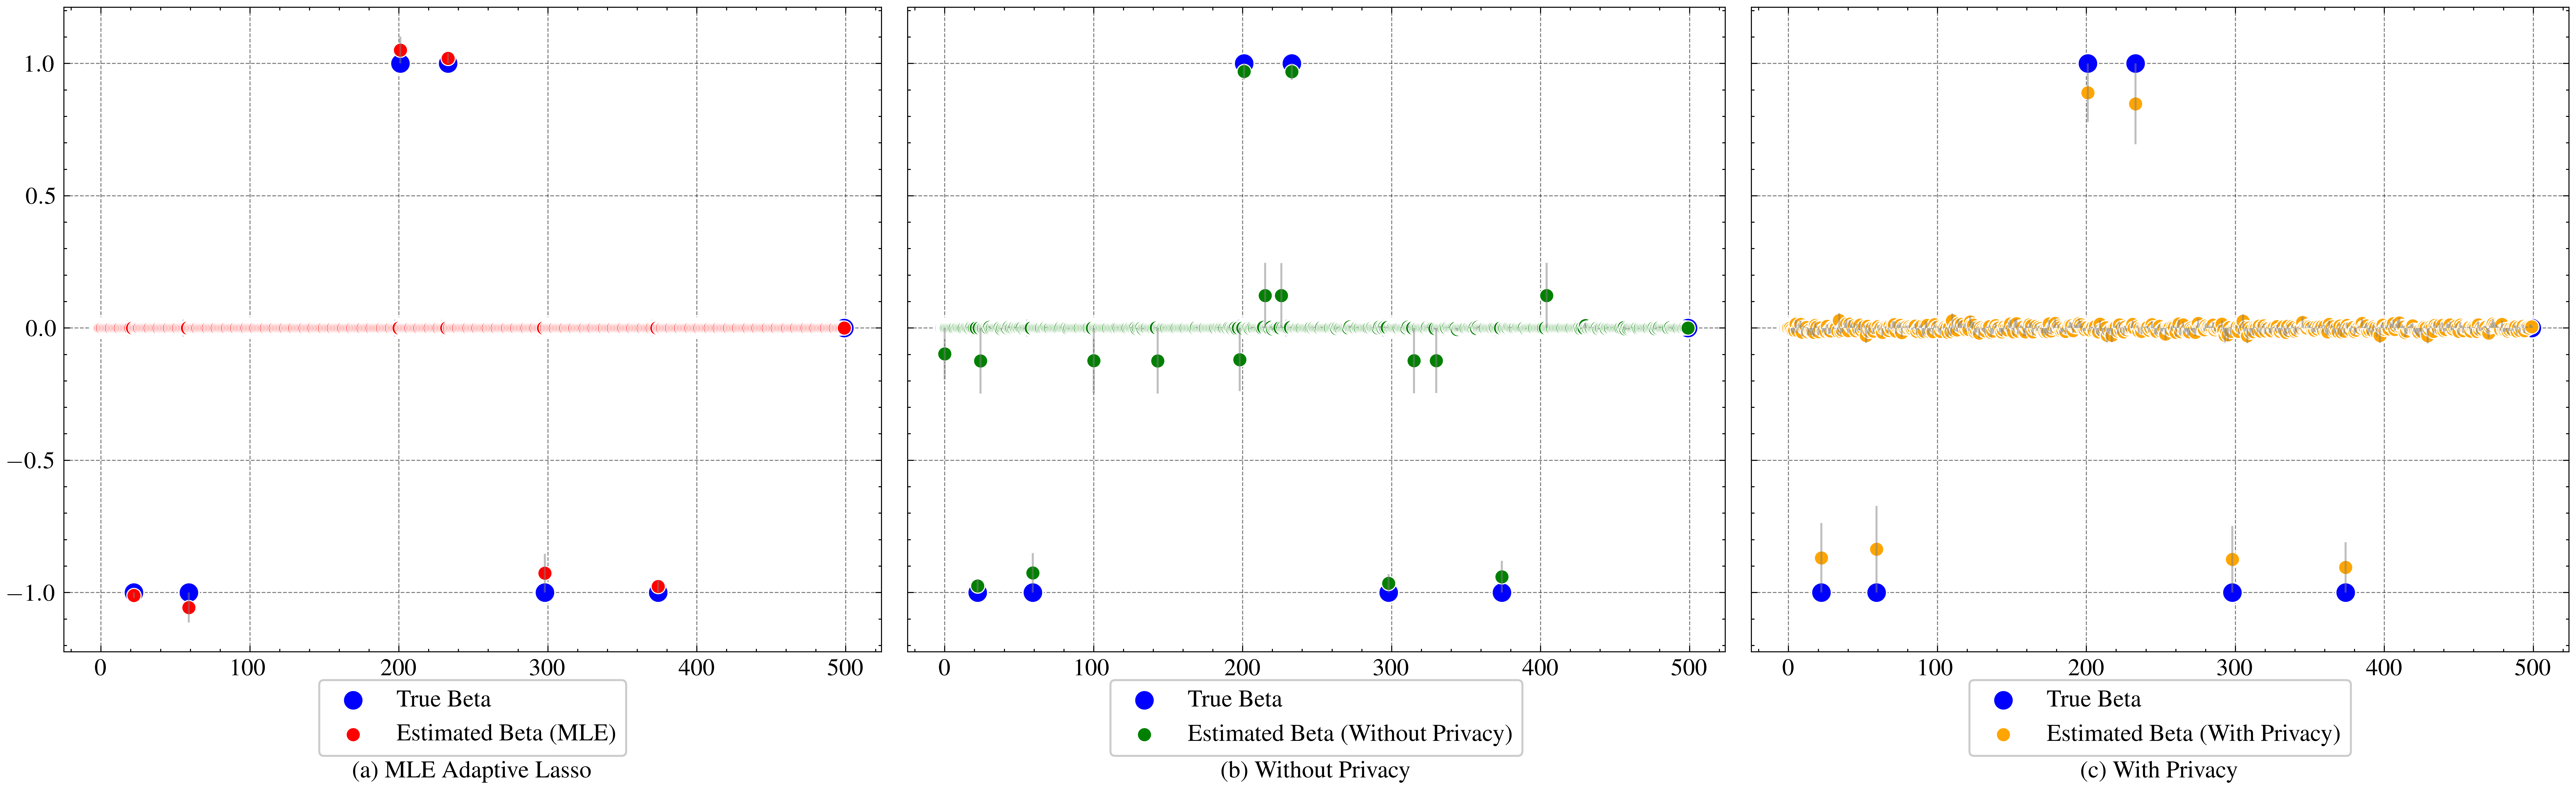

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# 设置全局字体和字号
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['pdf.fonttype'] = 42  # 嵌入 TrueType 字体，确保矢量输出
plt.rcParams['ps.fonttype'] = 42
def plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private):
    # 创建包含三个子图的画布
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # 定义颜色和标签
    true_color = 'blue'
    mle_color = 'red'
    without_private_color = 'green'
    with_private_color = 'orange'
    
    label_true = 'True Beta'
    label_mle = 'Estimated Beta (MLE)'
    label_without_private = 'Estimated Beta (Without Privacy)'
    label_with_private = 'Estimated Beta (With Privacy)'
    
    indices = np.arange(len(beta_true))
    
    # (a) MLE Adaptive Lasso
    sns.scatterplot(x=indices, y=beta_true, ax=axes[0], color=true_color, label=label_true, s=100)
    sns.scatterplot(x=indices, y=beta_hat_mle, ax=axes[0], color=mle_color, label=label_mle, s=50)
    axes[0].errorbar(indices, beta_hat_mle, yerr=np.abs(beta_hat_mle - beta_true), fmt='none', color='gray', alpha=0.5)

    axes[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.18))  # legend 位置更低
    axes[0].set_xlabel('(a) MLE Adaptive Lasso', fontsize=12, labelpad=40)  # xlabel (标题) 更低

    # (b) Without Privacy
    sns.scatterplot(x=indices, y=beta_true, ax=axes[1], color=true_color, label=label_true, s=100)
    sns.scatterplot(x=indices, y=beta_hat_without_private, ax=axes[1], color=without_private_color, label=label_without_private, s=50)
    axes[1].errorbar(indices, beta_hat_without_private, yerr=np.abs(beta_hat_without_private - beta_true), fmt='none', color='gray', alpha=0.5)

    axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.18))
    axes[1].set_xlabel('(b) Without Privacy', fontsize=12, labelpad=40)

    # (c) With Privacy
    sns.scatterplot(x=indices, y=beta_true, ax=axes[2], color=true_color, label=label_true, s=100)
    sns.scatterplot(x=indices, y=beta_hat_private, ax=axes[2], color=with_private_color, label=label_with_private, s=50)
    axes[2].errorbar(indices, beta_hat_private, yerr=np.abs(beta_hat_private - beta_true), fmt='none', color='gray', alpha=0.5)

    axes[2].legend(loc='lower center', bbox_to_anchor=(0.5, -0.18))
    axes[2].set_xlabel('(c) With Privacy', fontsize=12, labelpad=40)

    # 调整整体布局，防止重叠
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # 调整底部空间
    plt.savefig('variable_selection_three.pdf',dpi=600, bbox_inches='tight', format='pdf', transparent=True)
    plt.show()

plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private)

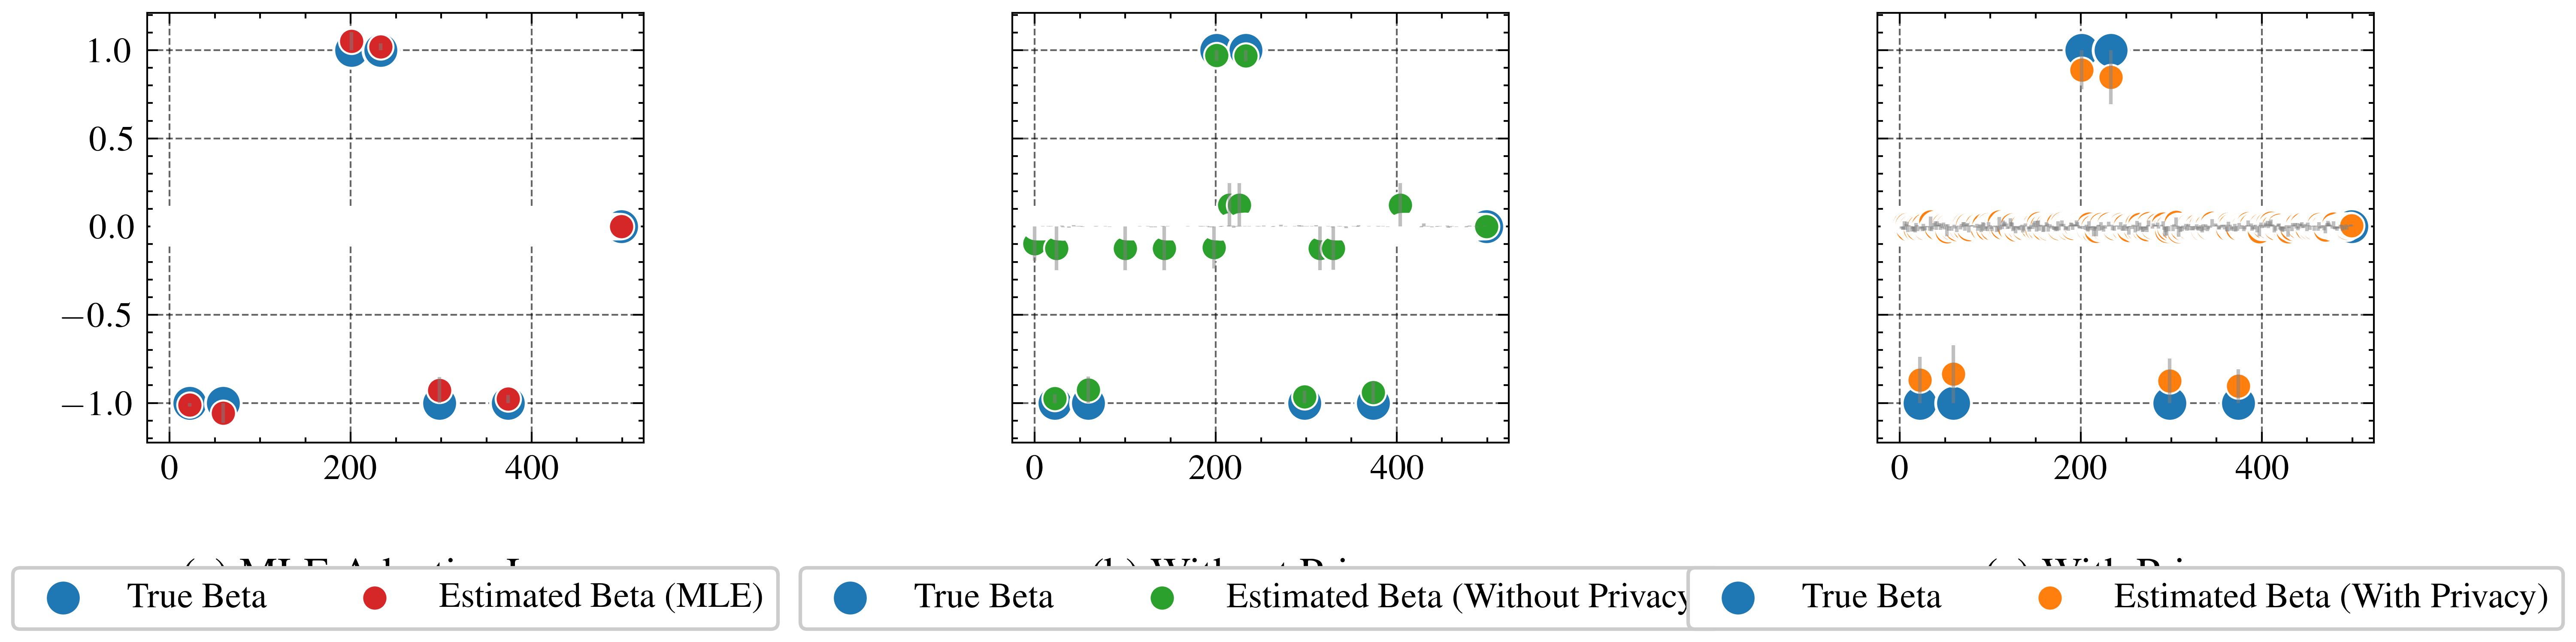

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots  # 添加 scienceplots 以保持风格一致

# 设置全局字体和字号，与论文一致
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['pdf.fonttype'] = 42  # 嵌入矢量字体
plt.rcParams['ps.fonttype'] = 42

# 设置 scienceplots 样式
plt.style.use(['science', 'ieee', 'grid'])

def plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private):
    # 创建画布，调整为适配 A4 的尺寸
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)  # 宽 10 英寸，高 3 英寸
    
    # 定义更深的颜色以提高对比度
    true_color = '#1f77b4'  # 深蓝色
    mle_color = '#d62728'   # 深红色
    without_private_color = '#2ca02c'  # 深绿色
    with_private_color = '#ff7f0e'  # 深橙色
    
    label_true = 'True Beta'
    label_mle = 'Estimated Beta (MLE)'
    label_without_private = 'Estimated Beta (Without Privacy)'
    label_with_private = 'Estimated Beta (With Privacy)'
    
    indices = np.arange(len(beta_true))
    
    # (a) MLE Adaptive Lasso
    sns.scatterplot(x=indices, y=beta_true, ax=axes[0], color=true_color, label=label_true, s=100)
    sns.scatterplot(x=indices, y=beta_hat_mle, ax=axes[0], color=mle_color, label=label_mle, s=50)
    axes[0].errorbar(indices, beta_hat_mle, yerr=np.abs(beta_hat_mle - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)  # 图例移至下方，调整位置
    axes[0].set_xlabel('(a) MLE Adaptive Lasso', fontsize=12, labelpad=20)  # 调整 labelpad
    
    # (b) Without Privacy
    sns.scatterplot(x=indices, y=beta_true, ax=axes[1], color=true_color, label=label_true, s=100)
    sns.scatterplot(x=indices, y=beta_hat_without_private, ax=axes[1], color=without_private_color, label=label_without_private, s=50)
    axes[1].errorbar(indices, beta_hat_without_private, yerr=np.abs(beta_hat_without_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)
    axes[1].set_xlabel('(b) Without Privacy', fontsize=12, labelpad=20)
    
    # (c) With Privacy
    sns.scatterplot(x=indices, y=beta_true, ax=axes[2], color=true_color, label=label_true, s=100)
    sns.scatterplot(x=indices, y=beta_hat_private, ax=axes[2], color=with_private_color, label=label_with_private, s=50)
    axes[2].errorbar(indices, beta_hat_private, yerr=np.abs(beta_hat_private - beta_true), fmt='none', color='gray', alpha=0.5)
    axes[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)
    axes[2].set_xlabel('(c) With Privacy', fontsize=12, labelpad=20)
    
    # 设置网格样式
    for ax in axes:
        ax.grid(True, linestyle='--', alpha=0.6)
    
    # 调整整体布局
    plt.tight_layout(pad=2.0)  # 增加 pad，确保图例不被裁剪
    
    # 保存为 PDF
    plt.savefig('variable_selection_three_version2.pdf', dpi=600, bbox_inches='tight', format='pdf', transparent=True)
    plt.show()


plot_variable_selection_comparison(beta_true, beta_hat_mle, beta_hat_without_private, beta_hat_private)